In [ ]:
!pip install fredapi requests yahoo_fin bs4 tabulate openai==0.28 anthropic google-generativeai rouge_score ace_tools faker
#!pip install llama_cpp_python

import yfinance as yf
import pandas as pd
import random
from fredapi import Fred
import requests
from yahoo_fin import news
from bs4 import BeautifulSoup
from tabulate import tabulate
import random
import openai
import anthropic
import faker
#from llama_cpp import Llama
import google.generativeai as genai
import re
import random
import nltk
import pandas as pd
from yahoo_fin import news
from datetime import datetime, timedelta
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import time
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import sentence_bleu
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')
import time

#to do: change the size of the datasets, change the time period of the datasets
#BOND DATA VERY IMPORTANT FOR THIS EXPERIMENT
#Future plan - maybe segregate the client data into sections for risk alignment, plans etc.
#and see which LLM performs better for which user set

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.9/82.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.2/144.2 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 4.9 MB/s eta 0:00:00
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=3b4c71f1b25d77a7ec8d8bbcfbab462f26151b2e1df5fb3ef1e194888beb7307
  Stored in directory: /root/.cache/pip/wheels/

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
#preprocessing training data for financial news articles
nltk_resources = ["punkt", "stopwords", "wordnet"]

for resource in nltk_resources:
    try:
        nltk.data.find(f"tokenizers/{resource}")
    except LookupError:
        print(f"🔹 Downloading missing NLTK resource: {resource}")
        nltk.download(resource)


stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


# 🔹 Download necessary NLTK resources (only needed once)
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

# 🔹 Initialize NLP components
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

# 🔹 List of S&P 500 stock tickers (expandable)
sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR"
]
sp500_tickers_test = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
]

# 🔹 Function to generate a random date between 2011 and 2021
def random_date():
    start_date = datetime(2011, 1, 1)
    end_date = datetime(2021, 12, 31)
    return start_date + timedelta(days=random.randint(0, (end_date - start_date).days))

# 🔹 Function to clean and preprocess text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    words = word_tokenize(text)  # Tokenization
    words = [word for word in words if word not in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(word) for word in words]  # Lemmatization
    return " ".join(words)

# 🔹 Fetch and process financial news for at least 100 random ticker-date pairs
news_data = []
attempts = 0

while len(news_data) < 500 and attempts < 2000:
    attempts += 1
    ticker = random.choice(sp500_tickers)
    date = random_date().strftime('%Y-%m-%d')

    try:

        latest_news = news.get_yf_rss(ticker)

        if latest_news:
            for article in latest_news[:1]:
                title = article["title"]
                link = article["link"]
                cleaned_title = clean_text(title)

                news_data.append({
                    "Ticker": ticker,
                    "Date": date,
                    "Original Title": title,
                    "Cleaned Title": cleaned_title,
                    "Link": link
                })

    except Exception as e:
        print(f"⚠️ Error fetching news for {ticker} on {date}: {e}")

df_news = pd.DataFrame(news_data)

import tabulate
print("\n📊 Processed Historical Financial News:\n")
print(tabulate.tabulate(df_news.head(100), headers="keys", tablefmt="fancy_grid"))

df_news.to_csv("historical_financial_news.csv", index=False)
print("Processed financial news saved to 'historical_financial_news.csv'")

🔹 Downloading missing NLTK resource: stopwords
🔹 Downloading missing NLTK resource: wordnet


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



📊 Processed Historical Financial News:

╒════╤══════════╤════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Ticker   │ Date       │ Original Title                                                                                                            │ Cleaned Title                                                                                                    │ Link                                                                                                                                                                         

In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
from tabulate import tabulate

# 🔹 Define S&P 500 tickers for testing
sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR"
]
# 🔹 Define financial features to extract
financial_features = ["Open", "High", "Low", "Close", "Volume"]

# 🔹 Time range for training data (2011-2021)
start_date = "2011-01-01"
end_date = "2021-12-31"

# 🔹 Dictionary to store financial data
financial_data = []

# 🔹 Fetch data for each ticker
for ticker in sp500_tickers:
    try:
        stock = yf.Ticker(ticker)
        df = stock.history(start=start_date, end=end_date)

        if not df.empty:
            df.reset_index(inplace=True)  # Ensure 'Date' is a column
            df["Ticker"] = ticker  # Add ticker column

            # 🔹 Ensure "Adj Close" is available, else use "Close"
            if "Adj Close" not in df.columns:
                df["Adj Close"] = df["Close"]

            # 🔹 Calculate Volatility (Rolling 20-day standard deviation of log returns)
            df["Log Return"] = np.log(df["Adj Close"] / df["Adj Close"].shift(1))
            df["Volatility"] = df["Log Return"].rolling(window=20).std() * np.sqrt(252)  # Annualized Volatility

            # 🔹 Select relevant columns
            df = df[["Date", "Ticker"] + financial_features + ["Adj Close", "Volatility"]]

            financial_data.append(df)

    except Exception as e:
        print(f"⚠️ Error fetching data for {ticker}: {e}")

# 🔹 Combine data into a single DataFrame
df_financials = pd.concat(financial_data, ignore_index=True)

# ✅ Step 1: Handle Missing Values
df_financials.dropna(inplace=True)  # Remove rows with missing values

# ✅ Step 2: Convert Date Column to Datetime
df_financials["Date"] = pd.to_datetime(df_financials["Date"])

# ✅ Step 3: Remove Outliers (Using IQR Method)
for column in ["Open", "High", "Low", "Close", "Adj Close", "Volatility"]:
    Q1 = df_financials[column].quantile(0.25)
    Q3 = df_financials[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_financials = df_financials[(df_financials[column] >= lower_bound) & (df_financials[column] <= upper_bound)]

# ✅ Step 4: Normalize Numerical Features (Min-Max Scaling)
for column in ["Open", "High", "Low", "Close", "Adj Close", "Volume", "Volatility"]:
    df_financials[column] = (df_financials[column] - df_financials[column].min()) / (df_financials[column].max() - df_financials[column].min())

# ✅ Save Cleaned Numerical Financial Data to CSV
df_financials.to_csv("financial_forecasting_cleaned.csv", index=False)
print("\n✅ Cleaned financial forecasting data with volatility saved to 'financial_forecasting_cleaned.csv'")

# 🔹 Display the first few rows using tabulate
print("\n📊 Cleaned Financial Forecasting Data (2011-2021) with Volatility:\n")
print(tabulate(df_financials.head(20), headers="keys", tablefmt="fancy_grid"))

ERROR:yfinance:$FB: possibly delisted; no timezone found
ERROR:yfinance:$MRO: possibly delisted; no timezone found



✅ Cleaned financial forecasting data with volatility saved to 'financial_forecasting_cleaned.csv'

📊 Cleaned Financial Forecasting Data (2011-2021) with Volatility:

╒═════╤═══════════════════════════╤══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═══════════╤═════════════╤══════════════╕
│     │ Date                      │ Ticker   │      Open │      High │       Low │     Close │    Volume │   Adj Close │   Volatility │
╞═════╪═══════════════════════════╪══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╪═════════════╪══════════════╡
│  20 │ 2021-12-30 00:00:00-05:00 │ AAPL     │ 0.459495  │ 0.460266  │ 0.459939  │ 0.459488  │ 1         │   0.459488  │    0.596871  │
├─────┼───────────────────────────┼──────────┼───────────┼───────────┼───────────┼───────────┼───────────┼─────────────┼──────────────┤
│  41 │ 2021-12-30 00:00:00-05:00 │ MSFT     │ 0.904581  │ 0.903898  │ 0.904471  │ 0.904575  │ 0.262239  │   0.904575  │    0.532528  │
├─────┼──────────

In [ ]:
#Sorting numerical and textual data based on ticker
import pandas as pd
from tabulate import tabulate

# 🔹 Load financial news dataset (Experiment 1)
df_news = pd.read_csv("historical_financial_news.csv")

# 🔹 Load numerical financial data (Experiment 2)
df_financials = pd.read_csv("financial_forecasting_cleaned.csv")

# 🔹 Convert Date column to datetime format in both datasets
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])

# 🔹 Sort each dataset by Ticker and Date
df_news_sorted = df_news.sort_values(by=["Ticker", "Date"])
df_financials_sorted = df_financials.sort_values(by=["Ticker", "Date"])

# ✅ Save sorted datasets to separate CSVs
df_news_sorted.to_csv("sorted_financial_news.csv", index=False)
df_financials_sorted.to_csv("sorted_financial_numerical_data.csv", index=False)

print("\n✅ Financial news sorted by Ticker and Date saved as 'sorted_financial_news.csv'")
print("✅ Numerical financial data sorted by Ticker and Date saved as 'sorted_financial_numerical_data.csv'")

# 📊 Display first few rows of each dataset
print("\n📊 Sorted Financial News Data:\n")
print(tabulate(df_news_sorted.head(20), headers="keys", tablefmt="fancy_grid"))

print("\n📊 Sorted Numerical Financial Data:\n")
print(tabulate(df_financials_sorted.head(20), headers="keys", tablefmt="fancy_grid"))



✅ Financial news sorted by Ticker and Date saved as 'sorted_financial_news.csv'
✅ Numerical financial data sorted by Ticker and Date saved as 'sorted_financial_numerical_data.csv'

📊 Sorted Financial News Data:

╒════╤══════════╤═════════════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Ticker   │ Date                │ Original Title                                                                                                            │ Cleaned Title                                                                                     

In [ ]:
# Initialize Faker for generating synthetic client profiles for TRAINING
fake = faker.Faker()

# Define risk tolerance categories
risk_levels = ["Low", "Moderate", "High"]
investment_goals = ["Wealth Growth", "Retirement Planning", "Short-Term Gains", "Passive Income", "Education Fund"]

# Define equity types from the S&P 500 classification
equity_types = [
    "Information Technology", "Communication Services", "Consumer Discretionary",
    "Financials", "Healthcare", "Industrials", "Consumer Staples", "Energy",
    "Materials", "Real Estate", "Utilities"
]
start_date = datetime(2011, 1, 1)
end_date = datetime(2021, 12, 31)
random_date = start_date + timedelta(days=random.randint(0, (end_date - start_date).days))

# Generate 20 random simulated client profiles
client_profiles = []
for _ in range(500):
    profile = {
        "Client ID": fake.unique.uuid4(),
        "Name": fake.name(),
        "Age": random.randint(25, 75),
        "Income": round(random.uniform(30000, 500000), 2),  # Annual income in USD
        "Risk Tolerance": random.choice(risk_levels),
        "Investment Goal": random.choice(investment_goals),
        "Initial Investment ($)": round(random.uniform(5000, 1000000), 2),  # Starting investment
        "Preferred Asset Classes": random.choice([random.choice(equity_types), "Mixed Portfolio"]),
        "Date Created": random_date.strftime("%Y-%m-%d")
    }
    client_profiles.append(profile)

# Convert to DataFrame
df_clients = pd.DataFrame(client_profiles)

# Save to CSV
csv_path = "simulated_client_profiles.csv"
df_clients.to_csv(csv_path, index=False)
from tabulate import tabulate
# Display the first few rows
print("\n📊 Simulated Client Profiles for training:\n")
print(tabulate(df_clients.head(10), headers="keys", tablefmt="fancy_grid"))

print(f"\n✅ Client profiles saved to: {csv_path}")


📊 Simulated Client Profiles for training:

╒════╤══════════════════════════════════════╤══════════════════╤═══════╤══════════╤══════════════════╤═════════════════════╤══════════════════════════╤═══════════════════════════╤════════════════╕
│    │ Client ID                            │ Name             │   Age │   Income │ Risk Tolerance   │ Investment Goal     │   Initial Investment ($) │ Preferred Asset Classes   │ Date Created   │
╞════╪══════════════════════════════════════╪══════════════════╪═══════╪══════════╪══════════════════╪═════════════════════╪══════════════════════════╪═══════════════════════════╪════════════════╡
│  0 │ 17b59fa8-4848-4cc3-bb6d-85759f382dd4 │ Alfred Fox       │    41 │  44319.4 │ Low              │ Wealth Growth       │                 674743   │ Industrials               │ 2021-01-29     │
├────┼──────────────────────────────────────┼──────────────────┼───────┼──────────┼──────────────────┼─────────────────────┼──────────────────────────┼─────────────────

In [ ]:
# Initialize Faker for generating synthetic client profiles for EVALUATION
fake = faker.Faker()

# Define risk tolerance categories
risk_levels = ["Low", "Moderate", "High"]
investment_goals = ["Wealth Growth", "Retirement Planning", "Short-Term Gains", "Passive Income", "Education Fund"]

# Define equity types from the S&P 500 classification
equity_types = [
    "Information Technology", "Communication Services", "Consumer Discretionary",
    "Financials", "Healthcare", "Industrials", "Consumer Staples", "Energy",
    "Materials", "Real Estate", "Utilities"
]

# Generate 5 new simulated client profiles for January 2, 2022
new_client_profiles = []
for _ in range(150):
    profile = {
        "Client ID": fake.unique.uuid4(),
        "Name": fake.name(),
        "Age": random.randint(25, 75),
        "Income": round(random.uniform(30000, 500000), 2),  # Annual income in USD
        "Risk Tolerance": random.choice(risk_levels),
        "Investment Goal": random.choice(investment_goals),
        "Initial Investment ($)": round(random.uniform(5000, 1000000), 2),  # Starting investment
        "Preferred Asset Classes": random.choice([random.choice(equity_types), "Mixed Portfolio"]),
        "Date Created": "2022-01-02",  # Fixed date for new clients
    }
    new_client_profiles.append(profile)

# Convert to DataFrame
df_new_clients = pd.DataFrame(new_client_profiles)

# Save to CSV
csv_path = "new_simulated_client_profiles.csv"
df_new_clients.to_csv(csv_path, index=False)

# Display the generated client profiles
print("\n📊 Newly Simulated Client Profiles (January 2, 2022):\n")
print(tabulate(df_new_clients.head(), headers="keys", tablefmt="fancy_grid"))

print(f"\n✅ New client profiles saved to: {csv_path}")


📊 Newly Simulated Client Profiles (January 2, 2022):

╒════╤══════════════════════════════════════╤════════════════════╤═══════╤══════════╤══════════════════╤═════════════════════╤══════════════════════════╤═══════════════════════════╤════════════════╕
│    │ Client ID                            │ Name               │   Age │   Income │ Risk Tolerance   │ Investment Goal     │   Initial Investment ($) │ Preferred Asset Classes   │ Date Created   │
╞════╪══════════════════════════════════════╪════════════════════╪═══════╪══════════╪══════════════════╪═════════════════════╪══════════════════════════╪═══════════════════════════╪════════════════╡
│  0 │ 46d44265-d3b2-482f-9dfa-b6e376e5989b │ Christina Mccall   │    49 │ 145600   │ Moderate         │ Retirement Planning │                 804557   │ Energy                    │ 2022-01-02     │
├────┼──────────────────────────────────────┼────────────────────┼───────┼──────────┼──────────────────┼─────────────────────┼───────────────────────

In [ ]:
# ✅ **Step 1: Rule-Based Investment Strategy with Mixed Portfolio & Cash**
def determine_investment_strategy(row):
    risk = row["Risk Tolerance"]
    goal = row["Investment Goal"]
    income = row["Income"]
    preferred_equity = row["Preferred Asset Classes"]

    # Initialize portfolio allocation with all investment options
    portfolio = {sector: 0 for sector in equity_sectors}

    # Step 1: Allocate based on risk tolerance
    if risk == "Low":
        portfolio[preferred_equity] = 20
        portfolio["Consumer Staples"] += 20  # Defensive sector
        portfolio["Utilities"] += 20
        portfolio["Real Estate"] += 10
        portfolio["Cash"] += 30  # Safe cash holding for low-risk clients
    elif risk == "Moderate":
        portfolio[preferred_equity] = 30
        portfolio["Healthcare"] += 15
        portfolio["Financials"] += 15
        portfolio["Industrials"] += 10
        portfolio["Mixed Portfolio"] += 30  # Balanced diversified approach
    else:  # High risk
        portfolio[preferred_equity] = 40
        portfolio["Information Technology"] += 20
        portfolio["Communication Services"] += 20
        portfolio["Consumer Discretionary"] += 10
        portfolio["Mixed Portfolio"] += 10  # Higher risk allocation with some diversification

    # Step 2: Adjust based on investment goal
    if goal in ["Short-Term Gains", "Passive Income"]:
        portfolio["Financials"] += 10  # High-yielding dividend stocks
        portfolio["Consumer Discretionary"] -= 5
        portfolio["Cash"] += 5  # Ensure some liquidity
    elif goal == "Retirement Planning":
        portfolio["Utilities"] += 10  # More stability
        portfolio["Mixed Portfolio"] += 10  # Diversification for long-term security

    # Step 3: Adjust based on income
    if income < 50000:
        portfolio["Consumer Staples"] += 10  # Defensive assets
        portfolio["Cash"] += 10  # More liquid savings for safety
    elif income > 150000:
        portfolio["Information Technology"] += 10  # More risk-taking for high-income clients
        portfolio["Mixed Portfolio"] += 10  # Diversified investments for long-term growth

      # ✅ Print portfolio if flag is enabled

    #print("\n📊 **Client Portfolio Allocation**")
    #print(f"Client: {row['Name']}")
    #print(f"Risk Level: {risk} | Investment Goal: {goal} | Income: ${income}")
    #for sector, percentage in portfolio.items():
    #      print(f"- {sector}: {percentage}%")
    #print("-" * 50)

    return portfolio


In [ ]:
def calculate_investment_distribution(allocation_percentages, initial_investment, equity_sectors, equity_sector_mapping):
    """
    Computes the investment distribution across tickers based on sector allocations.

    Parameters:
    - allocation_percentages (list): Allocation percentages for each sector.
    - initial_investment (float): Initial amount invested.
    - equity_sectors (list): List of all equity sectors including "Mixed Portfolio" and "Cash".
    - equity_sector_mapping (dict): Mapping of sectors to tickers.

    Returns:
    - investment_distribution (dict): Dictionary of allocated amounts per ticker.
    """

    # Extract specific percentages for Mixed Portfolio and Cash
    mixed_portfolio_percentage = allocation_percentages[equity_sectors.index("Mixed Portfolio")]
    cash_percentage = allocation_percentages[equity_sectors.index("Cash")]

    # Calculate cash and mixed portfolio allocations
    mixed_portfolio_amount = (mixed_portfolio_percentage / 100) * initial_investment
    cash_amount = (cash_percentage / 100) * initial_investment

    # Remaining investment after Mixed Portfolio and Cash allocations
    remaining_investment = initial_investment - (mixed_portfolio_amount + cash_amount)

    # Initialize investment distribution dictionary
    investment_distribution = {ticker: 0 for tickers in equity_sector_mapping.values() for ticker in tickers}
    investment_distribution["Cash"] = cash_amount  # Start with the cash allocation

    # Allocate investments sector-wise (excluding Mixed Portfolio & Cash initially)
    for i, sector in enumerate(equity_sectors[:-2]):  # Ignore last two: Mixed Portfolio & Cash
        sector_percentage = allocation_percentages[i]
        sector_allocation = (sector_percentage / 100) * remaining_investment  # Exclude mixed & cash portions

        if sector in equity_sector_mapping:
            tickers_in_sector = equity_sector_mapping[sector]

            if len(tickers_in_sector) > 0:
                for ticker in tickers_in_sector:
                    investment_distribution[ticker] += sector_allocation / len(tickers_in_sector)
            else:
                # If no tickers exist for a sector, add money to Cash
                investment_distribution["Cash"] += sector_allocation

    # Allocate the Mixed Portfolio funds evenly across all sectors (excluding cash)
    if mixed_portfolio_percentage > 0:
        available_tickers = [ticker for tickers in equity_sector_mapping.values() for ticker in tickers]
        if len(available_tickers) > 0:
            equal_allocation = mixed_portfolio_amount / len(available_tickers)
            for ticker in available_tickers:
                investment_distribution[ticker] += equal_allocation
        else:
            investment_distribution["Cash"] += mixed_portfolio_amount  # If no tickers exist, add to Cash

    # Ensure total allocation matches the initial investment
    total_investment = sum(investment_distribution.values())
    rem_investment = (initial_investment - total_investment)

    for key in investment_distribution:
        if total_investment != 0:  # Avoid division by zero
          investment_distribution[key] += (investment_distribution[key] / total_investment) * rem_investment
        else:
          investment_distribution[key] += 0

    return investment_distribution

In [ ]:
def calculate_profit(investment_distributions, df_financials, initial_investment):
    """
    Calculates the final investment value and profit/loss percentage.

    Parameters:
    - investment_distributions (list of dicts): Investment allocations per ticker.
    - df_financials (DataFrame): Stock data containing closing prices.
    - initial_investment (float): Initial amount invested.

    Returns:
    - total_value (float): The final value of the investment.
    - totalprofitpercentage (float): The percentage profit or loss.
    """
    final_values = []

    for investment in investment_distributions:
        if investment is None:
            final_values.append(None)
            continue

        total_value = investment.get("Cash", 0)  # Start with cash holdings

        for ticker, amount in investment.items():
            if ticker == "Cash":
                continue  # Skip cash in stock calculations

            # Fetch closing price on 31st Dec 2021
            price_data = df_financials[
                (df_financials["Ticker"] == ticker) &
                (df_financials["Date"] == "2021-12-30 00:00:00-05:00")
            ]

            if not price_data.empty:
                closing_price = price_data["Close"].values[0]
                total_value += amount * closing_price  # Compute final value

        final_values.append(total_value)

    # Compute profit/loss percentage
    totalprofitpercentage = (((total_value / initial_investment) * -100)
                             if total_value < initial_investment
                             else ((total_value / initial_investment) * 100))

    return total_value, totalprofitpercentage

In [ ]:
def calculate_profit_two(investment_distributions, df_financials, initial_investment):
    """
    Calculates the final investment value and profit/loss percentage.

    Parameters:
    - investment_distributions (list of dicts): Investment allocations per ticker.
    - df_financials (DataFrame): Stock data containing closing prices.
    - initial_investment (float): Initial amount invested.

    Returns:
    - total_value (float): The final value of the investment.
    - totalprofitpercentage (float): The percentage profit or loss.
    """
    final_values = []

    for investment in investment_distributions:
        if investment is None:
            final_values.append(None)
            continue

        total_value = investment.get("Cash", 0)  # Start with cash holdings

        for ticker, amount in investment.items():
            if ticker == "Cash":
                continue  # Skip cash in stock calculations

            # Fetch closing price on 31st Dec 2024
            price_data = df_financials[
                (df_financials["Ticker"] == ticker) &
                (df_financials["Date"] == "2024-12-30 00:00:00-05:00")
            ]

            if not price_data.empty:
                closing_price = price_data["Close"].values[0]
                total_value += amount * closing_price  # Compute final value

        final_values.append(total_value)

    # Compute profit/loss percentage
    totalprofitpercentage = (((total_value / initial_investment) * -100)
                             if total_value < initial_investment
                             else ((total_value / initial_investment) * 100))

    return total_value, totalprofitpercentage

In [ ]:
# Training and evaluation of Anthropic Claude
df_news = pd.read_csv("sorted_financial_news.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
df_clients = pd.read_csv("simulated_client_profiles.csv")
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
# 🔹 Convert Date column to datetime format for consistency
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_clients["Date"] = pd.to_datetime(df_clients["Date Created"])
df_newclients["Date"] = pd.to_datetime(df_newclients["Date Created"])

# Define the tickers and their corresponding sectors
sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR"
]

investment_options = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR", "Mixed Allocations", "Cash"
]

# Define the equity sectors and their associated tickers
equity_sector_mapping = {
    "Information Technology": ["AAPL", "MSFT", "NVDA", "INTC", "CSCO", "ORCL", "ADBE", "PYPL", "CDNS"],
    "Communication Services": ["GOOGL", "FB", "NFLX", "T"],
    "Consumer Discretionary": ["AMZN", "TSLA", "DIS", "NKE", "MCD", "TGT", "DG"],
    "Financials": ["JPM", "V", "MA", "GS", "C", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "USB", "MET", "BK", "COF", "FIS", "PGR"],
    "Healthcare": ["PFE", "UNH", "MRK", "TMO", "CI", "ISRG", "ZTS", "SYK", "GILD", "MDT"],
    "Industrials": ["GE", "BA", "MMM", "LMT", "CAT", "HON", "DE", "CSX", "FDX", "EMR", "NSC", "WM", "ITW"],
    "Consumer Staples": ["PG", "PEP", "KO", "EL", "MO"],
    "Energy": ["XOM", "CVX", "SLB", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "BKR"],
    "Materials": ["DOW", "APD", "ECL", "NEM"],
    "Real Estate": ["PLD", "AMT"],
    "Utilities": ["SO", "DUK", "AEP"],
}

# Function to categorize tickers into equity sectors
def categorize_tickers(ticker_list):
    categorized_tickers = {sector: [] for sector in equity_sector_mapping.keys()}

    for ticker in ticker_list:
        for sector, tickers in equity_sector_mapping.items():
            if ticker in tickers:
                categorized_tickers[sector].append(ticker)

    return categorized_tickers

# Categorize the given tickers
categorized_tickers = categorize_tickers(sp500_tickers_test)


df_financials = pd.read_csv("sorted_financial_numerical_data.csv")

# 🔹 Initialize Anthropic Claude API
CLAUDE_API_KEY = ""   # Replace with your actual API key
client = anthropic.Anthropic(api_key=CLAUDE_API_KEY)
begin = time.time()
# ✅ Step 1: Chain-of-Thought Training Prompt
'''
training_prompt_template = """
You are an AI trained in financial forecasting using Chain-of-Thought reasoning.
You will analyze a set of financial news articles from the year 2021, as well as corresponding stock data for the same time periods.
This is a part of your training, as you will then be asked to analyze a set of client profiles and provide personalized investment recommendations for the same.
Use the information you obtain from the articles and stock data to guide your decision when fed with client profiles in the future.
Do this in under 500 characters

**Instructions:**
1️⃣ **Extract Key Phrases:** Identify key financial terms, earnings results, and market-moving factors.
2️⃣ **Analyze Market Trends:** Compare the article with the latest market data (closing price, volume, volatility).
3️⃣ **Predict Impact on Market:** Based on the news content and historical price movements, estimate the market sentiment.
4️⃣ **Estimate Next-Day Price Movement:** Predict whether the asset price will rise, fall, or stay neutral.

---

**Financial News Article**:
"{article}"

**Stock/Bond Market Data**:
- Ticker: {ticker}
- Date: {date}
- Previous Close Price: {close}
- Volume: {volume}
- Volatility: {volatility}
---

**Your Response**:
Step 1️⃣ Key Phrases → [Extracted key financial terms]
Step 2️⃣ Market Analysis → [Interpret market trends based on financial data]
Step 3️⃣ Impact Prediction → [Classify sentiment as Positive/Negative/Neutral]
Step 4️⃣ Price Movement Prediction → [Up/Down/Neutral]
Final Answer: [Predicted Price Change]
"""

# ✅ Step 2: Train Claude on Financial News & Market Data
training_results = []
reward_score = 0  # Initialize reinforcement learning score

# Iterate through both datasets simultaneously (assuming they are aligned)
for index in range(len(df_news)):
    row_news = df_news.iloc[index]
    row_financials = df_financials.iloc[index]

    ticker = row_news["Ticker"]
    date = row_news["Date"]
    article_text = row_news["Cleaned Title"]
    close_price = row_financials["Close"]
    volume = row_financials["Volume"]
    volatility = row_financials["Volatility"]

    # Format the Chain-of-Thought prompt
    formatted_prompt = training_prompt_template.format(
        article=article_text,
        ticker=ticker,
        date=date,
        close=close_price,
        volume=volume,
        volatility=volatility
    )

    # Send training data to Claude API
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=500,
        temperature=0.5,
        messages=[{"role": "user", "content": formatted_prompt}]
    )

'''
equity_sectors = [
    "Information Technology", "Communication Services", "Consumer Discretionary",
    "Financials", "Healthcare", "Industrials", "Consumer Staples", "Energy",
    "Materials", "Real Estate", "Utilities", "Mixed Portfolio", "Cash"
]




# Define Chain-of-Thought (CoT) investment prompt
investment_prompt_template = """
You are a financial advisor trained in investment strategies.
Analyze the following client profile and allocate their portfolio using only the approved asset classes:

✅ **Allowed Investments:**
- S&P 500 Equity Sectors: {equity_sectors}
- Mixed Portfolio (Balanced across multiple sectors)
- Holding(Cash)

📌 **Rules:**
1. **Assess Risk Tolerance**: Higher risk allows for more aggressive sector allocations.
2. **Match Investment Goals**: Align sector allocation with short-term vs long-term goals.
3. **Adjust for Income**: High-income clients can afford more risk; low-income clients need stability.
4. **Allocate Only Approved Asset Classes**: No bonds, crypto, or individual stocks.
5. **Ensure Total Allocation of all investments sums to exactly 100% and not more or less - TOP PRIORITY**



---
**Client Profile**
- **Client ID**: {client_id}
- **Name**: {name}
- **Age**: {age}
- **Income**: ${income}
- **Risk Tolerance**: {risk_tolerance}
- **Investment Goal**: {investment_goal}
- **Initial Investment**: ${initial_investment}
- **Preferred Asset Class**: {preferred_asset}

---
📊 Final Investment Allocation (Percentages Only) - please answer in the format listed below
- Information Technology: __%
- Communication Services: __%
- Consumer Discretionary: __%
- Financials: __%
- Healthcare: __%
- Industrials: __%
- Consumer Staples: __%
- Energy: __%
- Materials: __%
- Real Estate: __%
- Utilities: __%
- Mixed Portfolio: __%
- Cash: __%

📌 **Ensure the total allocation sums to 100%**
"""

# Store investment advice results
investment_results = []
investment_distributions = []
investment_distributions_new = []
final_values = []
# Iterate through each client profile
for _, row in df_clients.iterrows():
    formatted_prompt = investment_prompt_template.format(
        client_id=row["Client ID"],
        name=row["Name"],
        age=row["Age"],
        income=row["Income"],
        risk_tolerance=row["Risk Tolerance"],
        investment_goal=row["Investment Goal"],
        initial_investment=row["Initial Investment ($)"],
        preferred_asset=row["Preferred Asset Classes"],
        equity_sectors=", ".join(equity_sectors)  # Provide the list of available investments
    )


    # Send the prompt to Claude AI
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=500,
        temperature=0.5,
        messages=[{"role": "user", "content": formatted_prompt}]
    )

    # Extract Claude's investment advice
    advice_text = response.content[0].text
    #print("Advice text = " + str(advice_text))
    print("advice text generated")

    def rmse(array1, array2):
      return np.sqrt(np.mean((np.array(array1) - np.array(array2)) ** 2))

    portfolio = determine_investment_strategy(row)
    portfolio_values = list(portfolio.values())
    #print("Rule Based Allocations = " + str(portfolio_values))
    allocation_percentages = []
    for sector in equity_sectors:
        match = re.search(rf"{sector}: (\d+)%", advice_text)
        allocation_percentages.append(int(match.group(1)) if match else 0)
    #print("LLM Alloc percentages" + str(allocation_percentages))
    allocRMSE = rmse(portfolio_values, allocation_percentages)
    #print("RMSE = " + str(allocRMSE))

    # Ensure the total allocation sums to 100%
    if sum(allocation_percentages) != 100:
        investment_distributions.append(None)
        continue

    # Get initial investment from client profile
    initial_investment = row["Initial Investment ($)"]
    #print("initial = " + str(initial_investment))
    # Extract specific percentages
    investment_distribution = calculate_investment_distribution(
        allocation_percentages, initial_investment, equity_sectors, equity_sector_mapping
    )

    # Store distribution results
    investment_distributions.append(investment_distribution)
    #print(investment_distributions)

    total_value, totalprofitpercentage = calculate_profit(
    investment_distributions, df_financials, initial_investment
)
    print("Profit/Loss = " + str(totalprofitpercentage) + "%")

    reward_score = 0  # Start with neutral reward

    # 🔹 Define Reward Function
    def compute_reward(allocRMSE, totalprofitpercentage):
        # Normalize RMSE (assuming max RMSE observed is 50 for scaling)
        normalized_rmse = allocRMSE / 50  # Scale RMSE between 0 and 1
        normalized_profit = totalprofitpercentage / 100  # Scale profit to [-1,1]

        # Define reward as weighted combination (adjust weights as needed)
        reward = (0.7 * normalized_profit) - (0.3 * normalized_rmse)
        #print("Reward = " + str(reward))
        return reward

    reward = compute_reward(allocRMSE, totalprofitpercentage)
    reward_score += reward  # Update cumulative reward

    # ✅ **Adjust Prompt for Next Iteration Based on Reinforcement Learning**
    if reward_score > 1:
        formatted_prompt += "\n✅ Previous allocations performed well! Maintain similar allocation patterns."
    elif reward_score < -1:
        formatted_prompt += "\n⚠️ Previous allocations deviated significantly or had losses. Adjust strategy to reduce RMSE and increase profits."
    else:
        formatted_prompt += "\n🔄 Moderate performance—some improvements are needed, but the strategy is stable."

# Convert investment results to DataFrame
# Convert investment results to DataFrame
df_investment = pd.DataFrame(investment_results)
df_investment["Investment Distribution"] = investment_distributions
df_investment["Allocation Percentages"] = [list(d.values()) if d else None for d in investment_distributions]

# 🔹 Define Claude Investment Prompt (Evaluation)
evaluation_prompt_template = """
You are a financial advisor trained using historical market data, financial news articles and client profiles from the year of 2021.
Using your training knowledge, analyze the following client profiles and generate an **investment allocation**.
Provide a step-by-step explanation, then allocate **only the allowed asset classes** in percentages.
Please limit your answer to 500 characters

✅ **Allowed Investments:**
- S&P 500 Equity Sectors: {equity_sectors}
- Mixed Portfolio (Balanced across multiple sectors)
- Holding (Cash)

📌 **Rules:**
1. **Assess Risk Tolerance** → Higher risk allows for aggressive investments.
2. **Match Investment Goals** → Align allocation with short-term vs long-term goals.
3. **Consider Income** → High-income clients can afford more risk.
4. **Ensure Total Allocation Sums to exactly 100%**


---
**Client Profile**
- **Client ID**: {client_id}
- **Name**: {name}
- **Age**: {age}
- **Income**: ${income}
- **Risk Tolerance**: {risk_tolerance}
- **Investment Goal**: {investment_goal}
- **Initial Investment**: ${initial_investment}
- **Preferred Asset Class**: {preferred_asset}

---
📊 Final Investment Allocation (Percentages Only) - please answer in the format listed below
- Information Technology: __%
- Communication Services: __%
- Consumer Discretionary: __%
- Financials: __%
- Healthcare: __%
- Industrials: __%
- Consumer Staples: __%
- Energy: __%
- Materials: __%
- Real Estate: __%
- Utilities: __%
- Mixed Portfolio: __%
- Cash: __%

📌 **Ensure the total allocation sums to 100%**
"""

# 🔹 Store Investment Explanations & Predictions Separately
investment_explanations = []
investment_allocations = []

# 🔹 Iterate Through Each New Client Profile
for _, row in df_newclients.iterrows():
    formatted_prompt = evaluation_prompt_template.format(
        client_id=row["Client ID"],
        name=row["Name"],
        age=row["Age"],
        income=row["Income"],
        risk_tolerance=row["Risk Tolerance"],
        investment_goal=row["Investment Goal"],
        initial_investment=row["Initial Investment ($)"],
        preferred_asset=row["Preferred Asset Classes"],
        equity_sectors=", ".join(equity_sectors)
    )

    # 🔹 Query Claude AI for Investment Advice
    response = client.messages.create(
        model="claude-3-7-sonnet-20250219",
        max_tokens=500,
        temperature=0.5,
        messages=[{"role": "user", "content": formatted_prompt}]
    )

    # 🔹 Extract Investment Explanation
    advice_text = response.content[0].text
    #print("Advice text = " + str(advice_text))
    investment_explanations.append({
        "Client ID": row["Client ID"],
        "Investment Explanation": advice_text
    })

    # 🔹 Extract Allocation Percentages from Response
    allocation_percentages = []
    for sector in equity_sectors:
        match = re.search(rf"{sector}: (\d+)%", advice_text)
        allocation_percentages.append(int(match.group(1)) if match else 0)
    #print("Allocation percentages = " + str(allocation_percentages))
    # 🔹 Store Allocation Percentages (Prediction)
    investment_allocations.append({
        "Client ID": row["Client ID"],
        "Allocation Percentages": allocation_percentages
    })

    print(f"✅ Processed Client {row['Client ID']}")

# 🔹 Convert Results to DataFrames
df_explanations = pd.DataFrame(investment_explanations)
df_allocations = pd.DataFrame(investment_allocations)
time.sleep(1)
end = time.time()
totalClaudetime = (end-begin)

# 🔹 Save Results to CSVs
df_explanations.to_csv("claude_investment_explanations.csv", index=False)
df_allocations.to_csv("claude_investment_predictions.csv", index=False)

print("\n✅ Investment Explanations saved to 'claude_investment_explanations.csv'")
print("✅ Investment Predictions saved to 'claude_investment_predictions.csv'")
print("Time taken = " + str(totalClaudetime))

advice text generated
Profit/Loss = -38.54367371256846%
advice text generated
Profit/Loss = -39.275317053567996%
advice text generated
Profit/Loss = -42.17547504422891%
advice text generated
Profit/Loss = -33.145295579607655%
advice text generated
Profit/Loss = -41.86793495889839%
advice text generated
Profit/Loss = -42.33286354066063%
advice text generated
Profit/Loss = -43.601573171436584%
advice text generated
Profit/Loss = -36.05877798875475%
advice text generated
Profit/Loss = -36.768747790834475%
advice text generated
Profit/Loss = -46.69734455417379%
advice text generated
Profit/Loss = -41.75764292640547%
advice text generated
Profit/Loss = -46.65950120961696%
advice text generated
Profit/Loss = -33.60648853193326%
advice text generated
Profit/Loss = -36.3526957654737%
advice text generated
Profit/Loss = -36.652617494127924%
advice text generated
Profit/Loss = -35.235677917079805%
advice text generated
Profit/Loss = -36.35872449372791%
advice text generated
Profit/Loss = -38.168

In [ ]:
#Training and evaluation of GPT 4o
df_news = pd.read_csv("sorted_financial_news.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
df_clients = pd.read_csv("simulated_client_profiles.csv")
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
# 🔹 Convert Date column to datetime format for consistency
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_clients["Date"] = pd.to_datetime(df_clients["Date Created"])
df_newclients["Date"] = pd.to_datetime(df_newclients["Date Created"])

# Define the tickers and their corresponding sectors
sp500_tickers_test = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
]
sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR"
]
investment_options = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR", "Mixed Allocations", "Cash"
]
# Define the equity sectors and their associated tickers
equity_sector_mapping = {
    "Information Technology": ["AAPL", "MSFT", "NVDA", "INTC", "CSCO", "ORCL", "ADBE", "PYPL", "CDNS"],
    "Communication Services": ["GOOGL", "FB", "NFLX", "T"],
    "Consumer Discretionary": ["AMZN", "TSLA", "DIS", "NKE", "MCD", "TGT", "DG"],
    "Financials": ["JPM", "V", "MA", "GS", "C", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "USB", "MET", "BK", "COF", "FIS", "PGR"],
    "Healthcare": ["PFE", "UNH", "MRK", "TMO", "CI", "ISRG", "ZTS", "SYK", "GILD", "MDT"],
    "Industrials": ["GE", "BA", "MMM", "LMT", "CAT", "HON", "DE", "CSX", "FDX", "EMR", "NSC", "WM", "ITW"],
    "Consumer Staples": ["PG", "PEP", "KO", "EL", "MO"],
    "Energy": ["XOM", "CVX", "SLB", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "BKR"],
    "Materials": ["DOW", "APD", "ECL", "NEM"],
    "Real Estate": ["PLD", "AMT"],
    "Utilities": ["SO", "DUK", "AEP"],
}

# Function to categorize tickers into equity sectors
def categorize_tickers(ticker_list):
    categorized_tickers = {sector: [] for sector in equity_sector_mapping.keys()}

    for ticker in ticker_list:
        for sector, tickers in equity_sector_mapping.items():
            if ticker in tickers:
                categorized_tickers[sector].append(ticker)

    return categorized_tickers

# Categorize the given tickers
categorized_tickers = categorize_tickers(sp500_tickers_test)


df_financials = pd.read_csv("sorted_financial_numerical_data.csv")


OPENAI_API_KEY = ''  # Replace with actual API key
openai.api_key = OPENAI_API_KEY
begin = time.time()
# ✅ Step 1: Chain-of-Thought Training Prompt
'''
training_prompt_template = """
You are an AI trained in financial forecasting using Chain-of-Thought reasoning.
You will analyze a set of financial news articles from the year 2021, as well as corresponding stock data for the same time periods.
This is a part of your training, as you will then be asked to analyze a set of client profiles and provide personalized investment recommendations for the same.
Use the information you obtain from the articles and stock data to guide your decision when fed with client profiles in the future.
Do this in under 500 characters

**Instructions:**
1. **Extract Key Phrases:** Identify key financial terms, earnings results, and market-moving factors.
2. **Analyze Market Trends:** Compare the article with the latest market data (closing price, volume, volatility).
3. **Predict Impact on Market:** Based on the news content and historical price movements, estimate the market sentiment.
4. **Estimate Next-Day Price Movement:** Predict whether the asset price will rise, fall, or stay neutral.

---

**Financial News Article**:
"{article}"

**Stock/Bond Market Data**:
- Ticker: {ticker}
- Date: {date}
- Previous Close Price: {close}
- Volume: {volume}
- Volatility: {volatility}
---

**Your Response**:
Step 1️⃣ Key Phrases → [Extracted key financial terms]
Step 2️⃣ Market Analysis → [Interpret market trends based on financial data]
Step 3️⃣ Impact Prediction → [Classify sentiment as Positive/Negative/Neutral]
Step 4️⃣ Price Movement Prediction → [Up/Down/Neutral]
Final Answer: [Predicted Price Change]
"""

# ✅ Step 2: Train Claude on Financial News & Market Data
training_results = []
reward_score = 0  # Initialize reinforcement learning score

# Iterate through both datasets simultaneously (assuming they are aligned)
for index in range(len(df_news)):
    row_news = df_news.iloc[index]
    row_financials = df_financials.iloc[index]

    ticker = row_news["Ticker"]
    date = row_news["Date"]
    article_text = row_news["Cleaned Title"]
    close_price = row_financials["Close"]
    volume = row_financials["Volume"]
    volatility = row_financials["Volatility"]

    # Format the Chain-of-Thought prompt
    formatted_prompt = training_prompt_template.format(
        article=article_text,
        ticker=ticker,
        date=date,
        close=close_price,
        volume=volume,
        volatility=volatility
    )

   response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": formatted_prompt}],
        max_tokens=500,
        temperature=0.5
    )


'''
equity_sectors = [
    "Information Technology", "Communication Services", "Consumer Discretionary",
    "Financials", "Healthcare", "Industrials", "Consumer Staples", "Energy",
    "Materials", "Real Estate", "Utilities", "Mixed Portfolio", "Cash"
]


# Define Chain-of-Thought (CoT) investment prompt
investment_prompt_template = """
You are a financial advisor trained in investment strategies.
Analyze the following client profile and allocate their portfolio using only the approved asset classes:

✅ **Allowed Investments:**
- S&P 500 Equity Sectors: {equity_sectors}
- Mixed Portfolio (Balanced across multiple sectors)
- Holding(Cash)

📌 **Rules:**
1. **Assess Risk Tolerance**: Higher risk allows for more aggressive sector allocations.
2. **Match Investment Goals**: Align sector allocation with short-term vs long-term goals.
3. **Adjust for Income**: High-income clients can afford more risk; low-income clients need stability.
4. **Allocate Only Approved Asset Classes**: No bonds, crypto, or individual stocks.
5. **Ensure Total Allocation of all investments sums to exactly 100% and not more or less - TOP PRIORITY**



---
**Client Profile**
- **Client ID**: {client_id}
- **Name**: {name}
- **Age**: {age}
- **Income**: ${income}
- **Risk Tolerance**: {risk_tolerance}
- **Investment Goal**: {investment_goal}
- **Initial Investment**: ${initial_investment}
- **Preferred Asset Class**: {preferred_asset}

---
📊 Final Investment Allocation (Percentages Only) - please answer in the format listed below
- Information Technology: __%
- Communication Services: __%
- Consumer Discretionary: __%
- Financials: __%
- Healthcare: __%
- Industrials: __%
- Consumer Staples: __%
- Energy: __%
- Materials: __%
- Real Estate: __%
- Utilities: __%
- Mixed Portfolio: __%
- Cash: __%

📌 **Ensure the total allocation sums to 100%**
"""

# Store investment advice results
investment_results = []
investment_distributions = []
investment_distributions_new = []
final_values = []
# Iterate through each client profile
for _, row in df_clients.iterrows():
    formatted_prompt = investment_prompt_template.format(
        client_id=row["Client ID"],
        name=row["Name"],
        age=row["Age"],
        income=row["Income"],
        risk_tolerance=row["Risk Tolerance"],
        investment_goal=row["Investment Goal"],
        initial_investment=row["Initial Investment ($)"],
        preferred_asset=row["Preferred Asset Classes"],
        equity_sectors=", ".join(equity_sectors)  # Provide the list of available investments
    )


    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": formatted_prompt}],
        max_tokens=500,
        temperature=0.5
    )


    # Extract Claude's investment advice
    advice_text = response["choices"][0]["message"]["content"]
    #print("Advice text = " + str(advice_text))
    print("advice text generated")

    def rmse(array1, array2):
      return np.sqrt(np.mean((np.array(array1) - np.array(array2)) ** 2))

    portfolio = determine_investment_strategy(row)
    portfolio_values = list(portfolio.values())
    #print("Rule Based Allocations = " + str(portfolio_values))
    allocation_percentages = []
    for sector in equity_sectors:
        match = re.search(rf"{sector}: (\d+)%", advice_text)
        allocation_percentages.append(int(match.group(1)) if match else 0)
    print("LLM Alloc percentages" + str(allocation_percentages))
    allocRMSE = rmse(portfolio_values, allocation_percentages)
    #print("RMSE = " + str(allocRMSE)
    print(sum(allocation_percentages))

    # Ensure the total allocation sums to 100%
    if sum(allocation_percentages) != 100:
        investment_distributions.append(None)
        print("test")
        continue

    # Get initial investment from client profile
    initial_investment = row["Initial Investment ($)"]
    #print("initial = " + str(initial_investment))
    # Extract specific percentages
    investment_distribution = calculate_investment_distribution(
        allocation_percentages, initial_investment, equity_sectors, equity_sector_mapping
    )
    print(investment_distribution)
    # Store distribution results
    investment_distributions.append(investment_distribution)

    total_value, totalprofitpercentage = calculate_profit(
    investment_distributions, df_financials, initial_investment
)
    print("Profit/Loss = " + str(totalprofitpercentage) + "%")

    reward_score = 0  # Start with neutral reward

    # 🔹 Define Reward Function
    def compute_reward(allocRMSE, totalprofitpercentage):
        # Normalize RMSE (assuming max RMSE observed is 50 for scaling)
        normalized_rmse = allocRMSE / 50  # Scale RMSE between 0 and 1
        normalized_profit = totalprofitpercentage / 100  # Scale profit to [-1,1]

        # Define reward as weighted combination (adjust weights as needed)
        reward = (0.7 * normalized_profit) - (0.3 * normalized_rmse)
        #print("Reward = " + str(reward))
        return reward

    reward = compute_reward(allocRMSE, totalprofitpercentage)
    reward_score += reward  # Update cumulative reward

    # ✅ **Adjust Prompt for Next Iteration Based on Reinforcement Learning**
    if reward_score > 1:
        formatted_prompt += "\n✅ Previous allocations performed well! Maintain similar allocation patterns."
    elif reward_score < -1:
        formatted_prompt += "\n⚠️ Previous allocations deviated significantly or had losses. Adjust strategy to reduce RMSE and increase profits."
    else:
        formatted_prompt += "\n🔄 Moderate performance—some improvements are needed, but the strategy is stable."

# Convert investment results to DataFrame
# Convert investment results to DataFrame
df_investment = pd.DataFrame(investment_results)
df_investment["Investment Distribution"] = investment_distributions
df_investment["Allocation Percentages"] = [list(d.values()) if d else None for d in investment_distributions]

# 🔹 Define Claude Investment Prompt (Evaluation)
evaluation_prompt_template = """
You are a financial advisor trained using historical market data, financial news articles and client profiles from the year of 2021.
Using your training knowledge, analyze the following client profiles and generate an **investment allocation**.
Provide a step-by-step explanation, then allocate **only the allowed asset classes** in percentages.
Please limit your answer to 500 characters

✅ **Allowed Investments:**
- S&P 500 Equity Sectors: {equity_sectors}
- Mixed Portfolio (Balanced across multiple sectors)
- Holding (Cash)

📌 **Rules:**
1. **Assess Risk Tolerance** → Higher risk allows for aggressive investments.
2. **Match Investment Goals** → Align allocation with short-term vs long-term goals.
3. **Consider Income** → High-income clients can afford more risk.
4. **Ensure Total Allocation Sums to 100%**
5. **Please allocate at least 5% for holding (cash)**

---
**Client Profile**
- **Client ID**: {client_id}
- **Name**: {name}
- **Age**: {age}
- **Income**: ${income}
- **Risk Tolerance**: {risk_tolerance}
- **Investment Goal**: {investment_goal}
- **Initial Investment**: ${initial_investment}
- **Preferred Asset Class**: {preferred_asset}

---
📊 Final Investment Allocation (Percentages Only) - please answer in the format listed below
- Information Technology: __%
- Communication Services: __%
- Consumer Discretionary: __%
- Financials: __%
- Healthcare: __%
- Industrials: __%
- Consumer Staples: __%
- Energy: __%
- Materials: __%
- Real Estate: __%
- Utilities: __%
- Mixed Portfolio: __%
- Cash: __%

📌 **Ensure the total allocation sums to 100%**
"""

# 🔹 Store Investment Explanations & Predictions Separately
investment_explanations = []
investment_allocations = []

# 🔹 Iterate Through Each New Client Profile
for _, row in df_newclients.iterrows():
    formatted_prompt = evaluation_prompt_template.format(
        client_id=row["Client ID"],
        name=row["Name"],
        age=row["Age"],
        income=row["Income"],
        risk_tolerance=row["Risk Tolerance"],
        investment_goal=row["Investment Goal"],
        initial_investment=row["Initial Investment ($)"],
        preferred_asset=row["Preferred Asset Classes"],
        equity_sectors=", ".join(equity_sectors)
    )

    # 🔹 Query Claude AI for Investment Advice
    response = openai.ChatCompletion.create(
        model="gpt-4o",
        messages=[{"role": "user", "content": formatted_prompt}],
        max_tokens=500,
        temperature=0.5
    )

    # 🔹 Extract GPT-4o Investment Explanation
    advice_text = response["choices"][0]["message"]["content"]
    #print("Advice text = " + str(advice_text))
    investment_explanations.append({
        "Client ID": row["Client ID"],
        "Investment Explanation": advice_text
    })


    # 🔹 Extract Allocation Percentages from Response
    allocation_percentages = []
    for sector in equity_sectors:
        match = re.search(rf"{sector}: (\d+)%", advice_text)
        allocation_percentages.append(int(match.group(1)) if match else 0)
    #print("Alloc percentages = " + str(allocation_percentages))
    # 🔹 Store Allocation Percentages (Prediction)
    investment_allocations.append({
        "Client ID": row["Client ID"],
        "Allocation Percentages": allocation_percentages
    })
    print(allocation_percentages)

    print(f"✅ Processed Client {row['Client ID']}")

# 🔹 Convert Results to DataFrames
df_explanations = pd.DataFrame(investment_explanations)
df_allocations = pd.DataFrame(investment_allocations)
time.sleep(1)
end = time.time()
totalGPTtime = (end-begin)

# 🔹 Save Results to CSVs
df_explanations.to_csv("gpt_investment_explanations.csv", index=False)
df_allocations.to_csv("gpt_investment_predictions.csv", index=False)

print("\n✅ Investment Explanations saved to 'gpt_investment_explanations.csv'")
print("✅ Investment Predictions saved to 'gpt_investment_predictions.csv'")
print("Time taken = " + str(totalGPTtime))

advice text generated
LLM Alloc percentages[10, 5, 5, 10, 15, 15, 10, 5, 5, 5, 5, 10, 10]
110
test
advice text generated
LLM Alloc percentages[5, 5, 5, 10, 10, 5, 10, 5, 5, 20, 10, 10, 0]
100
{'AAPL': 408.81901482238686, 'MSFT': 408.81901482238686, 'NVDA': 408.81901482238686, 'INTC': 408.81901482238686, 'CSCO': 408.81901482238686, 'ORCL': 408.81901482238686, 'ADBE': 408.81901482238686, 'PYPL': 408.81901482238686, 'CDNS': 408.81901482238686, 'GOOGL': 823.4232043828265, 'FB': 823.4232043828265, 'NFLX': 823.4232043828265, 'T': 823.4232043828265, 'AMZN': 503.5856867219159, 'TSLA': 503.5856867219159, 'DIS': 503.5856867219159, 'NKE': 503.5856867219159, 'MCD': 503.5856867219159, 'TGT': 503.5856867219159, 'DG': 503.5856867219159, 'JPM': 408.81901482238686, 'V': 408.81901482238686, 'MA': 408.81901482238686, 'GS': 408.81901482238686, 'C': 408.81901482238686, 'BLK': 408.81901482238686, 'SCHW': 408.81901482238686, 'CME': 408.81901482238686, 'AON': 408.81901482238686, 'SPGI': 408.81901482238686, 'M

In [ ]:
from huggingface_hub import login
from google.colab import userdata
HF_TOKEN=userdata.get('test_token')

if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("Token is not set. Please save the token first.")

Successfully logged in to Hugging Face!


In [ ]:
#Training and evaluation of Meta Llama 3.2
'''
df_news = pd.read_csv("sorted_financial_news.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
df_clients = pd.read_csv("simulated_client_profiles.csv")
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
# 🔹 Convert Date column to datetime format for consistency
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_clients["Date"] = pd.to_datetime(df_clients["Date Created"])
df_newclients["Date"] = pd.to_datetime(df_newclients["Date Created"])

# Define the tickers and their corresponding sectors
sp500_tickers_test = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
]

# Define the equity sectors and their associated tickers
equity_sector_mapping = {
    "Information Technology": ["AAPL", "MSFT", "NVDA"],
    "Communication Services": ["GOOGL", "FB"],
    "Consumer Discretionary": ["AMZN", "TSLA", "DIS"],
    "Financials": ["JPM", "V"],
}

# Function to categorize tickers into equity sectors
def categorize_tickers(ticker_list):
    categorized_tickers = {sector: [] for sector in equity_sector_mapping.keys()}

    for ticker in ticker_list:
        for sector, tickers in equity_sector_mapping.items():
            if ticker in tickers:
                categorized_tickers[sector].append(ticker)

    return categorized_tickers

# Categorize the given tickers
categorized_tickers = categorize_tickers(sp500_tickers_test)


df_financials = pd.read_csv("sorted_financial_numerical_data.csv")


model_name = "meta-llama/Meta-Llama-3-3B-Instruct"
device = "cuda" if torch.cuda.is_available() else "cpu"
begin = time.time()
# ✅ Step 1: Chain-of-Thought Training Prompt
'''

'''
training_prompt_template = """
You are an AI trained in financial forecasting using Chain-of-Thought reasoning.
You will analyze a set of financial news articles from the year 2021, as well as corresponding stock data for the same time periods.
This is a part of your training, as you will then be asked to analyze a set of client profiles and provide personalized investment recommendations for the same.
Use the information you obtain from the articles and stock data to guide your decision when fed with client profiles in the future.
Do this in under 500 characters

**Instructions:**
1️⃣ **Extract Key Phrases:** Identify key financial terms, earnings results, and market-moving factors.
2️⃣ **Analyze Market Trends:** Compare the article with the latest market data (closing price, volume, volatility).
3️⃣ **Predict Impact on Market:** Based on the news content and historical price movements, estimate the market sentiment.
4️⃣ **Estimate Next-Day Price Movement:** Predict whether the asset price will rise, fall, or stay neutral.

---

**Financial News Article**:
"{article}"

**Stock/Bond Market Data**:
- Ticker: {ticker}
- Date: {date}
- Previous Close Price: {close}
- Volume: {volume}
- Volatility: {volatility}
---

**Your Response**:
Step 1️⃣ Key Phrases → [Extracted key financial terms]
Step 2️⃣ Market Analysis → [Interpret market trends based on financial data]
Step 3️⃣ Impact Prediction → [Classify sentiment as Positive/Negative/Neutral]
Step 4️⃣ Price Movement Prediction → [Up/Down/Neutral]
Final Answer: [Predicted Price Change]
"""

# ✅ Step 2: Train Claude on Financial News & Market Data
training_results = []
reward_score = 0  # Initialize reinforcement learning score

# Iterate through both datasets simultaneously (assuming they are aligned)
for index in range(len(df_news)):
    row_news = df_news.iloc[index]
    row_financials = df_financials.iloc[index]

    ticker = row_news["Ticker"]
    date = row_news["Date"]
    article_text = row_news["Cleaned Title"]
    close_price = row_financials["Close"]
    volume = row_financials["Volume"]
    volatility = row_financials["Volatility"]

    # Format the Chain-of-Thought prompt
    formatted_prompt = training_prompt_template.format(
        article=article_text,
        ticker=ticker,
        date=date,
        close=close_price,
        volume=volume,
        volatility=volatility
    )

    inputs = tokenizer(formatted_prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)

    # 🔹 Generate Investment Advice
    with torch.no_grad():
        output = model.generate(**inputs, max_length=1024, temperature=0.5)

    )
'''

'''
equity_sectors = [
    "Information Technology", "Communication Services", "Consumer Discretionary",
    "Financials", "Healthcare", "Industrials", "Consumer Staples", "Energy",
    "Materials", "Real Estate", "Utilities", "Mixed Portfolio", "Cash"
]

equity_sector_mapping = {
    "Information Technology": ["AAPL", "MSFT", "NVDA"],
    "Communication Services": ["GOOGL", "FB"],
    "Consumer Discretionary": ["AMZN", "TSLA", "DIS"],
    "Financials": ["JPM", "V"],
}
investment_options = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS", "Mixed Allocations", "Cash"
]

# Define Chain-of-Thought (CoT) investment prompt
investment_prompt_template = """
You are a financial advisor trained in investment strategies.
Analyze the following client profile and allocate their portfolio using only the approved asset classes:

✅ **Allowed Investments:**
- S&P 500 Equity Sectors: {equity_sectors}
- Mixed Portfolio (Balanced across multiple sectors)
- Holding(Cash)

📌 **Rules:**
1. **Assess Risk Tolerance**: Higher risk allows for more aggressive sector allocations.
2. **Match Investment Goals**: Align sector allocation with short-term vs long-term goals.
3. **Adjust for Income**: High-income clients can afford more risk; low-income clients need stability.
4. **Allocate Only Approved Asset Classes**: No bonds, crypto, or individual stocks.
5. **Please allocate at least 5% for holding (cash)**
6. **Ensure Total Allocation Sums to 100%**

---
**Client Profile**
- **Client ID**: {client_id}
- **Name**: {name}
- **Age**: {age}
- **Income**: ${income}
- **Risk Tolerance**: {risk_tolerance}
- **Investment Goal**: {investment_goal}
- **Initial Investment**: ${initial_investment}
- **Preferred Asset Class**: {preferred_asset}

---
📊 Final Investment Allocation (Percentages Only) - please answer in the format listed below
- Information Technology: __%
- Communication Services: __%
- Consumer Discretionary: __%
- Financials: __%
- Healthcare: __%
- Industrials: __%
- Consumer Staples: __%
- Energy: __%
- Materials: __%
- Real Estate: __%
- Utilities: __%
- Mixed Portfolio: __%
- Cash: __%

📌 **Ensure the total allocation sums to 100%**
"""

# Store investment advice results
investment_results = []
investment_distributions = []
investment_distributions_new = []
final_values = []
# Iterate through each client profile
for _, row in df_clients.iterrows():
    formatted_prompt = investment_prompt_template.format(
        client_id=row["Client ID"],
        name=row["Name"],
        age=row["Age"],
        income=row["Income"],
        risk_tolerance=row["Risk Tolerance"],
        investment_goal=row["Investment Goal"],
        initial_investment=row["Initial Investment ($)"],
        preferred_asset=row["Preferred Asset Classes"],
        equity_sectors=", ".join(equity_sectors)  # Provide the list of available investments
    )


   inputs = tokenizer(formatted_prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)

    # 🔹 Generate Investment Advice
    with torch.no_grad():
        output = model.generate(**inputs, max_length=1024, temperature=0.5)

    # 🔹 Decode output
    advice_text = tokenizer.decode(output[0], skip_special_tokens=True)
    #print("Advice text = " + str(advice_text))
    #print("advice text generated")

    def rmse(array1, array2):
      return np.sqrt(np.mean((np.array(array1) - np.array(array2)) ** 2))

    portfolio = determine_investment_strategy(row)
    portfolio_values = list(portfolio.values())
    #print("Rule Based Allocations = " + str(portfolio_values))
    allocation_percentages = []
    for sector in equity_sectors:
        match = re.search(rf"{sector}: (\d+)%", advice_text)
        allocation_percentages.append(int(match.group(1)) if match else 0)
    #print("LLM Alloc percentages" + str(allocation_percentages))
    allocRMSE = rmse(portfolio_values, allocation_percentages)
    #print("RMSE = " + str(allocRMSE))

    # Ensure the total allocation sums to 100%
    if sum(allocation_percentages) != 100:
        investment_distributions.append(None)
        continue

    # Get initial investment from client profile
    initial_investment = row["Initial Investment ($)"]
    #print("initial = " + str(initial_investment))
    # Extract specific percentages
    investment_distribution = calculate_investment_distribution(
        allocation_percentages, initial_investment, equity_sectors, equity_sector_mapping
    )

    # Store distribution results
    investment_distributions.append(investment_distribution)
    #print(investment_distributions)

    total_value, totalprofitpercentage = calculate_profit(
    investment_distributions, df_financials, initial_investment
)
    print("Profit/Loss = " + str(totalprofitpercentage) + "%")

    reward_score = 0  # Start with neutral reward

    # 🔹 Define Reward Function
    def compute_reward(allocRMSE, totalprofitpercentage):
        # Normalize RMSE (assuming max RMSE observed is 50 for scaling)
        normalized_rmse = allocRMSE / 50  # Scale RMSE between 0 and 1
        normalized_profit = totalprofitpercentage / 100  # Scale profit to [-1,1]

        # Define reward as weighted combination (adjust weights as needed)
        reward = (0.7 * normalized_profit) - (0.3 * normalized_rmse)
        #print("Reward = " + str(reward))
        return reward

    reward = compute_reward(allocRMSE, totalprofitpercentage)
    reward_score += reward  # Update cumulative reward

    # ✅ **Adjust Prompt for Next Iteration Based on Reinforcement Learning**
    if reward_score > 1:
        formatted_prompt += "\n✅ Previous allocations performed well! Maintain similar allocation patterns."
    elif reward_score < -1:
        formatted_prompt += "\n⚠️ Previous allocations deviated significantly or had losses. Adjust strategy to reduce RMSE and increase profits."
    else:
        formatted_prompt += "\n🔄 Moderate performance—some improvements are needed, but the strategy is stable."

# Convert investment results to DataFrame
# Convert investment results to DataFrame
df_investment = pd.DataFrame(investment_results)
df_investment["Investment Distribution"] = investment_distributions
df_investment["Allocation Percentages"] = [list(d.values()) if d else None for d in investment_distributions]

# 🔹 Define Claude Investment Prompt (Evaluation)
evaluation_prompt_template = """
You are a financial advisor trained using historical market data, financial news articles and client profiles from the year of 2021.
Using your training knowledge, analyze the following client profiles and generate an **investment allocation**.
Provide a step-by-step explanation, then allocate **only the allowed asset classes** in percentages.

✅ **Allowed Investments:**
- S&P 500 Equity Sectors: {equity_sectors}
- Mixed Portfolio (Balanced across multiple sectors)
- Holding (Cash)

📌 **Rules:**
1. **Assess Risk Tolerance** → Higher risk allows for aggressive investments.
2. **Match Investment Goals** → Align allocation with short-term vs long-term goals.
3. **Consider Income** → High-income clients can afford more risk.
4. **Ensure Total Allocation Sums to 100%**
5. **Please allocate at least 5% for holding (cash)**

---
**Client Profile**
- **Client ID**: {client_id}
- **Name**: {name}
- **Age**: {age}
- **Income**: ${income}
- **Risk Tolerance**: {risk_tolerance}
- **Investment Goal**: {investment_goal}
- **Initial Investment**: ${initial_investment}
- **Preferred Asset Class**: {preferred_asset}

---
📊 **Final Investment Allocation (Percentages Only)**
- Information Technology: __%
- Communication Services: __%
- Consumer Discretionary: __%
- Financials: __%
- Healthcare: __%
- Industrials: __%
- Consumer Staples: __%
- Energy: __%
- Materials: __%
- Real Estate: __%
- Utilities: __%
- Mixed Portfolio: __%
- Cash: __%

📌 **Ensure the total allocation sums to 100%**
"""

# 🔹 Store Investment Explanations & Predictions Separately
investment_explanations = []
investment_allocations = []

# 🔹 Iterate Through Each New Client Profile
for _, row in df_newclients.iterrows():
    formatted_prompt = evaluation_prompt_template.format(
        client_id=row["Client ID"],
        name=row["Name"],
        age=row["Age"],
        income=row["Income"],
        risk_tolerance=row["Risk Tolerance"],
        investment_goal=row["Investment Goal"],
        initial_investment=row["Initial Investment ($)"],
        preferred_asset=row["Preferred Asset Classes"],
        equity_sectors=", ".join(equity_sectors)
    )

    inputs = tokenizer(formatted_prompt, return_tensors="pt", truncation=True, max_length=1024).to(device)

    # 🔹 Generate Investment Advice
    with torch.no_grad():
        output = model.generate(**inputs, max_length=1024, temperature=0.5)

    # 🔹 Decode output
    advice_text = tokenizer.decode(output[0], skip_special_tokens=True)
    investment_explanations.append({
        "Client ID": row["Client ID"],
        "Investment Explanation": advice_text
    })


    # 🔹 Extract Allocation Percentages from Response
    allocation_percentages = []
    for sector in equity_sectors:
        match = re.search(rf"{sector}: (\d+)%", advice_text)
        allocation_percentages.append(int(match.group(1)) if match else 0)

    # 🔹 Store Allocation Percentages (Prediction)
    investment_allocations.append({
        "Client ID": row["Client ID"],
        "Allocation Percentages": allocation_percentages
    })

    print(f"✅ Processed Client {row['Client ID']}")

# 🔹 Convert Results to DataFrames
df_explanations = pd.DataFrame(investment_explanations)
df_allocations = pd.DataFrame(investment_allocations)
time.sleep(1)
end = time.time()
totalLlamatime = (end-begin)

# 🔹 Save Results to CSVs
df_explanations.to_csv("llama_investment_explanations.csv", index=False)
df_allocations.to_csv("llama_investment_predictions.csv", index=False)

print("\n✅ Investment Explanations saved to 'llama_investment_explanations.csv'")
print("✅ Investment Predictions saved to 'llama_investment_predictions.csv'")
print("Time taken = " + str(totalLlamatime))
'''

'\nequity_sectors = [\n    "Information Technology", "Communication Services", "Consumer Discretionary",\n    "Financials", "Healthcare", "Industrials", "Consumer Staples", "Energy",\n    "Materials", "Real Estate", "Utilities", "Mixed Portfolio", "Cash"\n]\n\nequity_sector_mapping = {\n    "Information Technology": ["AAPL", "MSFT", "NVDA"],\n    "Communication Services": ["GOOGL", "FB"],\n    "Consumer Discretionary": ["AMZN", "TSLA", "DIS"],\n    "Financials": ["JPM", "V"],\n}\ninvestment_options = [\n    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS", "Mixed Allocations", "Cash"\n]\n\n# Define Chain-of-Thought (CoT) investment prompt\ninvestment_prompt_template = """\nYou are a financial advisor trained in investment strategies.\nAnalyze the following client profile and allocate their portfolio using only the approved asset classes:\n\n✅ **Allowed Investments:**\n- S&P 500 Equity Sectors: {equity_sectors}\n- Mixed Portfolio (Balanced across multiple sectors

In [ ]:
#Training and evaluation of Google Gemini
#To use if LLaMa doesn't work - https://ai.google.dev/gemini-api/docs/quickstart?lang=python
df_news = pd.read_csv("sorted_financial_news.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
df_clients = pd.read_csv("simulated_client_profiles.csv")
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
# 🔹 Convert Date column to datetime format for consistency
df_news["Date"] = pd.to_datetime(df_news["Date"])
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_clients["Date"] = pd.to_datetime(df_clients["Date Created"])
df_newclients["Date"] = pd.to_datetime(df_newclients["Date Created"])

# Define the tickers and their corresponding sectors
sp500_tickers_test = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS"
]
sp500_tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR"
]
investment_options = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR", "Mixed Allocations", "Cash"
]

# Define the equity sectors and their associated tickers
equity_sector_mapping = {
    "Information Technology": ["AAPL", "MSFT", "NVDA", "INTC", "CSCO", "ORCL", "ADBE", "PYPL", "CDNS"],
    "Communication Services": ["GOOGL", "FB", "NFLX", "T"],
    "Consumer Discretionary": ["AMZN", "TSLA", "DIS", "NKE", "MCD", "TGT", "DG"],
    "Financials": ["JPM", "V", "MA", "GS", "C", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "USB", "MET", "BK", "COF", "FIS", "PGR"],
    "Healthcare": ["PFE", "UNH", "MRK", "TMO", "CI", "ISRG", "ZTS", "SYK", "GILD", "MDT"],
    "Industrials": ["GE", "BA", "MMM", "LMT", "CAT", "HON", "DE", "CSX", "FDX", "EMR", "NSC", "WM", "ITW"],
    "Consumer Staples": ["PG", "PEP", "KO", "EL", "MO"],
    "Energy": ["XOM", "CVX", "SLB", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "BKR"],
    "Materials": ["DOW", "APD", "ECL", "NEM"],
    "Real Estate": ["PLD", "AMT"],
    "Utilities": ["SO", "DUK", "AEP"],
}

# Function to categorize tickers into equity sectors
def categorize_tickers(ticker_list):
    categorized_tickers = {sector: [] for sector in equity_sector_mapping.keys()}

    for ticker in ticker_list:
        for sector, tickers in equity_sector_mapping.items():
            if ticker in tickers:
                categorized_tickers[sector].append(ticker)

    return categorized_tickers

# Categorize the given tickers
categorized_tickers = categorize_tickers(sp500_tickers_test)


df_financials = pd.read_csv("sorted_financial_numerical_data.csv")


GEMINI_API_KEY = ""  # Replace with actual API key
genai.configure(api_key=GEMINI_API_KEY)
model = genai.GenerativeModel("gemini-2.0-flash")
begin = time.time()
# ✅ Step 1: Chain-of-Thought Training Prompt
'''
training_prompt_template = """
You are an AI trained in financial forecasting using Chain-of-Thought reasoning.
You will analyze a set of financial news articles from the year 2021, as well as corresponding stock data for the same time periods.
This is a part of your training, as you will then be asked to analyze a set of client profiles and provide personalized investment recommendations for the same.
Use the information you obtain from the articles and stock data to guide your decision when fed with client profiles in the future.
Do this in under 500 characters

**Instructions:**
1. **Extract Key Phrases:** Identify key financial terms, earnings results, and market-moving factors.
2. **Analyze Market Trends:** Compare the article with the latest market data (closing price, volume, volatility).
3. **Predict Impact on Market:** Based on the news content and historical price movements, estimate the market sentiment.
4. **Estimate Next-Day Price Movement:** Predict whether the asset price will rise, fall, or stay neutral.

---

**Financial News Article**:
"{article}"

**Stock/Bond Market Data**:
- Ticker: {ticker}
- Date: {date}
- Previous Close Price: {close}
- Volume: {volume}
- Volatility: {volatility}
---

**Your Response**:
Step 1️⃣ Key Phrases → [Extracted key financial terms]
Step 2️⃣ Market Analysis → [Interpret market trends based on financial data]
Step 3️⃣ Impact Prediction → [Classify sentiment as Positive/Negative/Neutral]
Step 4️⃣ Price Movement Prediction → [Up/Down/Neutral]
Final Answer: [Predicted Price Change]
"""

# ✅ Step 2: Train Claude on Financial News & Market Data
training_results = []
reward_score = 0  # Initialize reinforcement learning score

# Iterate through both datasets simultaneously (assuming they are aligned)
for index in range(len(df_news)):
    row_news = df_news.iloc[index]
    row_financials = df_financials.iloc[index]

    ticker = row_news["Ticker"]
    date = row_news["Date"]
    article_text = row_news["Cleaned Title"]
    close_price = row_financials["Close"]
    volume = row_financials["Volume"]
    volatility = row_financials["Volatility"]

    # Format the Chain-of-Thought prompt
    formatted_prompt = training_prompt_template.format(
        article=article_text,
        ticker=ticker,
        date=date,
        close=close_price,
        volume=volume,
        volatility=volatility
    )

    response = model.generate_content(formatted_prompt)
    response_text = response.text



'''
equity_sectors = [
    "Information Technology", "Communication Services", "Consumer Discretionary",
    "Financials", "Healthcare", "Industrials", "Consumer Staples", "Energy",
    "Materials", "Real Estate", "Utilities", "Mixed Portfolio", "Cash"
]

equity_sector_mapping = {
    "Information Technology": ["AAPL", "MSFT", "NVDA"],
    "Communication Services": ["GOOGL", "FB"],
    "Consumer Discretionary": ["AMZN", "TSLA", "DIS"],
    "Financials": ["JPM", "V"],
}
investment_options = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS", "Mixed Allocations", "Cash"
]

# Define Chain-of-Thought (CoT) investment prompt
investment_prompt_template = """
You are a financial advisor trained in investment strategies.
Analyze the following client profile and allocate their portfolio using only the approved asset classes:

✅ **Allowed Investments:**
- S&P 500 Equity Sectors: {equity_sectors}
- Mixed Portfolio (Balanced across multiple sectors)
- Holding(Cash)

📌 **Rules:**
1. **Assess Risk Tolerance**: Higher risk allows for more aggressive sector allocations.
2. **Match Investment Goals**: Align sector allocation with short-term vs long-term goals.
3. **Adjust for Income**: High-income clients can afford more risk; low-income clients need stability.
4. **Allocate Only Approved Asset Classes**: No bonds, crypto, or individual stocks.
5. **Please allocate at least 5% for holding (cash)**
6. **Ensure Total Allocation Sums to 100%**

---
**Client Profile**
- **Client ID**: {client_id}
- **Name**: {name}
- **Age**: {age}
- **Income**: ${income}
- **Risk Tolerance**: {risk_tolerance}
- **Investment Goal**: {investment_goal}
- **Initial Investment**: ${initial_investment}
- **Preferred Asset Class**: {preferred_asset}

---
📊 Final Investment Allocation (Percentages Only) - please answer in the format listed below, and only answer with each allocation once
📌 **Ensure the total allocation sums to 100 EXACTLY, not more and not less**

- Information Technology: __%
- Communication Services: __%
- Consumer Discretionary: __%
- Financials: __%
- Healthcare: __%
- Industrials: __%
- Consumer Staples: __%
- Energy: __%
- Materials: __%
- Real Estate: __%
- Utilities: __%
- Mixed Portfolio: __%
- Cash: __%

📌
"""

# Store investment advice results
investment_results = []
investment_distributions = []
investment_distributions_new = []
final_values = []
reward_scores_list = []
# Iterate through each client profile
for _, row in df_clients.iterrows():
    formatted_prompt = investment_prompt_template.format(
        client_id=row["Client ID"],
        name=row["Name"],
        age=row["Age"],
        income=row["Income"],
        risk_tolerance=row["Risk Tolerance"],
        investment_goal=row["Investment Goal"],
        initial_investment=row["Initial Investment ($)"],
        preferred_asset=row["Preferred Asset Classes"],
        equity_sectors=", ".join(equity_sectors)  # Provide the list of available investments
    )


    response = model.generate_content(formatted_prompt)
    response_text = response.text

    #print(response_text)
    allocation_percentages = [int(num) for num in re.findall(r"(\d+)%", response_text)]
    allocation_percentages = allocation_percentages[:13]
    print(allocation_percentages)
    #advice_text = response["choices"][0]["message"]["content"]
    #print("Advice text = " + str(advice_text))
    #print("advice text generated")

    def rmse(array1, array2):
      return np.sqrt(np.mean((np.array(array1) - np.array(array2)) ** 2))

    portfolio = determine_investment_strategy(row)
    portfolio_values = list(portfolio.values())
    #print("Rule Based Allocations = " + str(portfolio_values))
    #allocation_percentages = []
    #for sector in equity_sectors:
    #    match = re.search(rf"{sector}: (\d+)%", advice_text)
    #    allocation_percentages.append(int(match.group(1)) if match else 0)
    #print("LLM Alloc percentages" + str(allocation_percentages))
    allocRMSE = rmse(portfolio_values, allocation_percentages)
    #print("RMSE = " + str(allocRMSE))

    print(sum(allocation_percentages))
    # Ensure the total allocation sums to 100%
    if sum(allocation_percentages) != 100:
        investment_distributions.append(None)
        continue

    # Get initial investment from client profile
    initial_investment = row["Initial Investment ($)"]
    #print("initial = " + str(initial_investment))
    # Extract specific percentages
    investment_distribution = calculate_investment_distribution(
        allocation_percentages, initial_investment, equity_sectors, equity_sector_mapping
    )

    # Store distribution results
    investment_distributions.append(investment_distribution)
    #print(investment_distributions)

    total_value, totalprofitpercentage = calculate_profit(
    investment_distributions, df_financials, initial_investment
)
    print("Profit/Loss = " + str(totalprofitpercentage) + "%")

    reward_score = 0  # Start with neutral reward

    # 🔹 Define Reward Function
    def compute_reward(allocRMSE, totalprofitpercentage):
        # Normalize RMSE (assuming max RMSE observed is 50 for scaling)
        normalized_rmse = allocRMSE / 50  # Scale RMSE between 0 and 1
        normalized_profit = totalprofitpercentage / 100  # Scale profit to [-1,1]

        # Define reward as weighted combination (adjust weights as needed)
        reward = (0.7 * normalized_profit) - (0.3 * normalized_rmse)
        #print("Reward = " + str(reward))
        return reward

    reward = compute_reward(allocRMSE, totalprofitpercentage)
    reward_score += reward  # Update cumulative reward

    reward_scores_list.append({
        "Ticker": ticker,
        "Date": date,
        "Reward Score": reward_score
    })

    # ✅ **Adjust Prompt for Next Iteration Based on Reinforcement Learning**
    if reward_score > 1:
        formatted_prompt += "\n✅ Previous allocations performed well! Maintain similar allocation patterns."
    elif reward_score < -1:
        formatted_prompt += "\n⚠️ Previous allocations deviated significantly or had losses. Adjust strategy to reduce RMSE and increase profits."
    else:
        formatted_prompt += "\n🔄 Moderate performance—some improvements are needed, but the strategy is stable."

# Convert investment results to DataFrame
# Convert investment results to DataFrame
df_investment = pd.DataFrame(investment_results)
df_investment["Investment Distribution"] = investment_distributions
df_investment["Allocation Percentages"] = [list(d.values()) if d else None for d in investment_distributions]

# 🔹 Define Claude Investment Prompt (Evaluation)
evaluation_prompt_template = """
You are a financial advisor trained using historical market data, financial news articles and client profiles from the year of 2021.
Using your training knowledge, analyze the following client profiles and generate an **investment allocation**.
Provide a step-by-step explanation, then allocate **only the allowed asset classes** in percentages.

✅ **Allowed Investments:**
- S&P 500 Equity Sectors: {equity_sectors}
- Mixed Portfolio (Balanced across multiple sectors)
- Holding (Cash)

📌 **Rules:**
1. **Assess Risk Tolerance** → Higher risk allows for aggressive investments.
2. **Match Investment Goals** → Align allocation with short-term vs long-term goals.
3. **Consider Income** → High-income clients can afford more risk.
4. **Ensure Total Allocation Sums to 100%**
5. **Please allocate at least 5% for holding (cash)**

---
**Client Profile**
- **Client ID**: {client_id}
- **Name**: {name}
- **Age**: {age}
- **Income**: ${income}
- **Risk Tolerance**: {risk_tolerance}
- **Investment Goal**: {investment_goal}
- **Initial Investment**: ${initial_investment}
- **Preferred Asset Class**: {preferred_asset}

---
📊 **Final Investment Allocation (Percentages Only) **
📌 **Ensure the total allocation sums to 100 EXACTLY, not more and not less**
- Information Technology: __%
- Communication Services: __%
- Consumer Discretionary: __%
- Financials: __%
- Healthcare: __%
- Industrials: __%
- Consumer Staples: __%
- Energy: __%
- Materials: __%
- Real Estate: __%
- Utilities: __%
- Mixed Portfolio: __%
- Cash: __%


"""

# 🔹 Store Investment Explanations & Predictions Separately
investment_explanations = []
investment_allocations = []

# 🔹 Iterate Through Each New Client Profile
for _, row in df_newclients.iterrows():
    formatted_prompt = evaluation_prompt_template.format(
        client_id=row["Client ID"],
        name=row["Name"],
        age=row["Age"],
        income=row["Income"],
        risk_tolerance=row["Risk Tolerance"],
        investment_goal=row["Investment Goal"],
        initial_investment=row["Initial Investment ($)"],
        preferred_asset=row["Preferred Asset Classes"],
        equity_sectors=", ".join(equity_sectors)
    )

    response = model.generate_content(formatted_prompt)
    response_text = response.text

    # 🔹 Extract Investment Explanation

    allocation_percentages = [int(num) for num in re.findall(r"(\d+)%", response_text)]
    allocation_percentages = allocation_percentages[:13]
    print(allocation_percentages)
    #advice_text = response["choices"][0]["message"]["content"]
    #print("Advice text = " + str(advice_text))
    #print("advice text generated")

    def rmse(array1, array2):
      return np.sqrt(np.mean((np.array(array1) - np.array(array2)) ** 2))

    portfolio = determine_investment_strategy(row)
    portfolio_values = list(portfolio.values())
    #print("Rule Based Allocations = " + str(portfolio_values))
    #allocation_percentages = []
    #for sector in equity_sectors:
    #    match = re.search(rf"{sector}: (\d+)%", advice_text)
    #    allocation_percentages.append(int(match.group(1)) if match else 0)
    #print("LLM Alloc percentages" + str(allocation_percentages))
    allocRMSE = rmse(portfolio_values, allocation_percentages)
    #print("RMSE = " + str(allocRMSE))
    investment_explanations.append({
        "Client ID": row["Client ID"],
        "Investment Explanation": response_text
    })


    # 🔹 Extract Allocation Percentages from Response


    # 🔹 Store Allocation Percentages (Prediction)
    investment_allocations.append({
        "Client ID": row["Client ID"],
        "Allocation Percentages": allocation_percentages
    })

    print(f"✅ Processed Client {row['Client ID']}")

# 🔹 Convert Results to DataFrames
df_explanations = pd.DataFrame(investment_explanations)
df_allocations = pd.DataFrame(investment_allocations)
time.sleep(1)
end = time.time()
totalGeminitime = (end-begin)

df_rewards = pd.DataFrame(reward_scores_list)
df_rewards.to_csv("gemini_reward_scores_training.csv", index=False)
print("\n✅ Reward scores saved to 'gemini_reward_scores_training.csv'")
# 🔹 Save Results to CSVs
df_explanations.to_csv("gemini_investment_explanations.csv", index=False)
df_allocations.to_csv("gemini_investment_predictions.csv", index=False)

print("\n✅ Investment Explanations saved to 'gemini_investment_explanations.csv'")
print("✅ Investment Predictions saved to 'gemini_investment_predictions.csv'")
print("Time taken = " + str(totalGeminitime))

[5, 3, 4, 6, 12, 15, 13, 3, 4, 5, 12, 13, 5]
100
Profit/Loss = -46.181326458148945%
[3, 2, 3, 5, 15, 3, 20, 4, 3, 20, 7, 10, 5]
100
Profit/Loss = -48.77981964634115%
[12, 5, 8, 7, 10, 6, 5, 5, 4, 3, 5, 25, 5]
100
Profit/Loss = -42.25397440317866%
[20, 15, 15, 10, 5, 10, 0, 5, 5, 0, 0, 10, 5]
100
Profit/Loss = -39.69753973150393%
[5, 3, 4, 6, 15, 5, 15, 3, 6, 8, 15, 15, 5]
105
[0, 0, 0, 0, 10, 0, 15, 0, 0, 0, 10, 60, 5]
100
Profit/Loss = -40.16947523178773%
[10, 5, 10, 10, 10, 5, 5, 5, 5, 15, 5, 15, 5]
105
[0, 0, 0, 5, 10, 0, 20, 5, 0, 10, 30, 15, 5]
100
Profit/Loss = -50.65430674266289%
[5, 3, 7, 5, 15, 5, 20, 3, 2, 5, 10, 15, 5]
100
Profit/Loss = -44.42511510514601%
[5, 3, 3, 4, 10, 4, 15, 3, 3, 5, 10, 30, 5]
100
Profit/Loss = -42.828536990742464%
[3, 2, 3, 5, 10, 5, 12, 5, 3, 7, 10, 30, 5]
100
Profit/Loss = -43.17207503822656%
[0, 0, 0, 0, 10, 0, 20, 0, 0, 0, 20, 45, 5]
100
Profit/Loss = -41.665238350993036%
[20, 10, 10, 10, 5, 10, 5, 5, 5, 5, 3, 7, 5]
100
Profit/Loss = -42.344118604

In [ ]:
import pandas as pd
from tabulate import tabulate

# 🔹 Load Claude's Results
df_claude_explanations = pd.read_csv("claude_investment_explanations.csv")
df_claude_predictions = pd.read_csv("claude_investment_predictions.csv")

# 🔹 Load GPT-4o's Results
df_gpt_explanations = pd.read_csv("gpt_investment_explanations.csv")
df_gpt_predictions = pd.read_csv("gpt_investment_predictions.csv")

# 🔹 Load Gemini's Results
df_gemini_explanations = pd.read_csv("gemini_investment_explanations.csv")
df_gemini_predictions = pd.read_csv("gemini_investment_predictions.csv")

# 🔹 Print First 5 Explanations from Claude
print("\n📊 Claude Investment Explanations:\n")
print(tabulate(df_claude_explanations.head(), headers="keys", tablefmt="fancy_grid"))

# 🔹 Print First 5 Predictions from Claude
print("\n📊 Claude Investment Predictions:\n")
print(tabulate(df_claude_predictions.head(), headers="keys", tablefmt="fancy_grid"))

# 🔹 Print First 5 Explanations from GPT-4o
print("\n📊 GPT-4o Investment Explanations:\n")
print(tabulate(df_gpt_explanations.head(), headers="keys", tablefmt="fancy_grid"))

# 🔹 Print First 5 Predictions from GPT-4o
print("\n📊 GPT-4o Investment Predictions:\n")
print(tabulate(df_gpt_predictions.head(), headers="keys", tablefmt="fancy_grid"))

# 🔹 Print First 5 Explanations from Gemini
print("\n📊 Gemini Investment Explanations:\n")
print(tabulate(df_gemini_explanations.head(), headers="keys", tablefmt="fancy_grid"))

# 🔹 Print First 5 Predictions from Gemini
print("\n📊 Gemini Investment Predictions:\n")
print(tabulate(df_gemini_predictions.head(), headers="keys", tablefmt="fancy_grid"))



📊 Claude Investment Explanations:

╒════╤══════════════════════════════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│    │ Client ID                            │ Investment Explanation                                                                                                                                       │
╞════╪══════════════════════════════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│  0 │ 46d44265-d3b2-482f-9dfa-b6e376e5989b │ Step 1: Assess client profile - 49-year-old with moderate risk tolerance, high income, and retirement focus.                                                 │
│    │                                      │ Step 2: Consider energy preference while balancing with age-appropriate diversification.          


📊 ROUGE F1 Score Comparison - Claude vs. GPT-4o vs. Gemini:

╒════╤═════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╤════════════════════════════╤════════════════════════════╤════════════════════════════╤═════════════════════════╤═════════════════════════╤═════════════════════════╕
│    │   Client Number │   ROUGE-1 Claude vs GPT │   ROUGE-2 Claude vs GPT │   ROUGE-L Claude vs GPT │   ROUGE-1 Claude vs Gemini │   ROUGE-2 Claude vs Gemini │   ROUGE-L Claude vs Gemini │   ROUGE-1 GPT vs Gemini │   ROUGE-2 GPT vs Gemini │   ROUGE-L GPT vs Gemini │
╞════╪═════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╪════════════════════════════╪════════════════════════════╪════════════════════════════╪═════════════════════════╪═════════════════════════╪═════════════════════════╡
│  0 │               1 │                  0.5025 │                  0.2132 │                  0.3719 │                     0.2844 │   

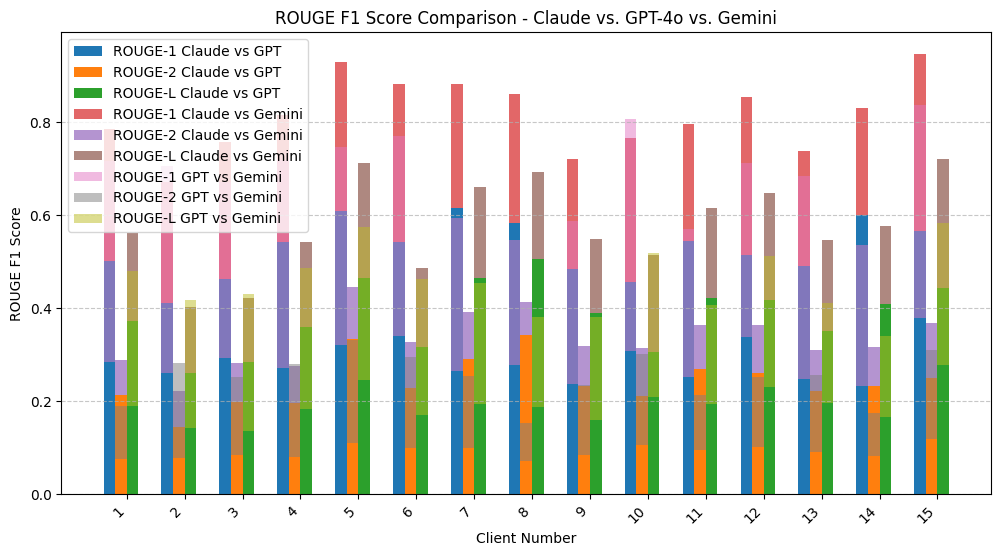

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from rouge_score import rouge_scorer

# 🔹 Load Claude, GPT-4o, and Gemini Investment Explanations
df_claude = pd.read_csv("claude_investment_explanations.csv")
df_gpt = pd.read_csv("gpt_investment_explanations.csv")
df_gemini = pd.read_csv("gemini_investment_explanations.csv")

# 🔹 Ensure DataFrames are aligned by Client ID
df_merged = pd.merge(df_claude, df_gpt, on="Client ID", suffixes=("_claude", "_gpt"))
df_merged = pd.merge(df_merged, df_gemini, on="Client ID")
df_merged.rename(columns={"Investment Explanation": "Investment Explanation_gemini"}, inplace=True)

# 🔹 Initialize ROUGE scorer
scorer = rouge_scorer.RougeScorer(["rouge1", "rouge2", "rougeL"], use_stemmer=True)

# 🔹 Compute ROUGE F1 Scores for all models
rouge_scores = []
for index, row in df_merged.iterrows():
    explanation_claude = row["Investment Explanation_claude"]
    explanation_gpt = row["Investment Explanation_gpt"]
    explanation_gemini = row["Investment Explanation_gemini"]

    # Compute ROUGE scores
    scores_claude_gpt = scorer.score(explanation_claude, explanation_gpt)
    scores_claude_gemini = scorer.score(explanation_claude, explanation_gemini)
    scores_gpt_gemini = scorer.score(explanation_gpt, explanation_gemini)

    rouge_f1 = {
        "Client Number": index + 1,  # Use index + 1 for sequential numbering
        "ROUGE-1 Claude vs GPT": round(scores_claude_gpt["rouge1"].fmeasure, 4),
        "ROUGE-2 Claude vs GPT": round(scores_claude_gpt["rouge2"].fmeasure, 4),
        "ROUGE-L Claude vs GPT": round(scores_claude_gpt["rougeL"].fmeasure, 4),
        "ROUGE-1 Claude vs Gemini": round(scores_claude_gemini["rouge1"].fmeasure, 4),
        "ROUGE-2 Claude vs Gemini": round(scores_claude_gemini["rouge2"].fmeasure, 4),
        "ROUGE-L Claude vs Gemini": round(scores_claude_gemini["rougeL"].fmeasure, 4),
        "ROUGE-1 GPT vs Gemini": round(scores_gpt_gemini["rouge1"].fmeasure, 4),
        "ROUGE-2 GPT vs Gemini": round(scores_gpt_gemini["rouge2"].fmeasure, 4),
        "ROUGE-L GPT vs Gemini": round(scores_gpt_gemini["rougeL"].fmeasure, 4),
    }
    rouge_scores.append(rouge_f1)

# 🔹 Convert to DataFrame
df_rouge = pd.DataFrame(rouge_scores)

# 🔹 Display the ROUGE F1 Score Table using tabulate
print("\n📊 ROUGE F1 Score Comparison - Claude vs. GPT-4o vs. Gemini:\n")
print(tabulate(df_rouge, headers="keys", tablefmt="fancy_grid"))

# 🔹 Plot ROUGE F1 Scores for each model comparison
plt.figure(figsize=(12, 6))
x_labels = np.arange(len(df_rouge))

plt.bar(x_labels - 0.3, df_rouge["ROUGE-1 Claude vs GPT"], width=0.2, label="ROUGE-1 Claude vs GPT")
plt.bar(x_labels - 0.1, df_rouge["ROUGE-2 Claude vs GPT"], width=0.2, label="ROUGE-2 Claude vs GPT")
plt.bar(x_labels + 0.1, df_rouge["ROUGE-L Claude vs GPT"], width=0.2, label="ROUGE-L Claude vs GPT")

plt.bar(x_labels - 0.3, df_rouge["ROUGE-1 Claude vs Gemini"], width=0.2, bottom=df_rouge["ROUGE-1 Claude vs GPT"], label="ROUGE-1 Claude vs Gemini", alpha=0.7)
plt.bar(x_labels - 0.1, df_rouge["ROUGE-2 Claude vs Gemini"], width=0.2, bottom=df_rouge["ROUGE-2 Claude vs GPT"], label="ROUGE-2 Claude vs Gemini", alpha=0.7)
plt.bar(x_labels + 0.1, df_rouge["ROUGE-L Claude vs Gemini"], width=0.2, bottom=df_rouge["ROUGE-L Claude vs GPT"], label="ROUGE-L Claude vs Gemini", alpha=0.7)

plt.bar(x_labels - 0.3, df_rouge["ROUGE-1 GPT vs Gemini"], width=0.2, bottom=df_rouge["ROUGE-1 Claude vs Gemini"], label="ROUGE-1 GPT vs Gemini", alpha=0.5)
plt.bar(x_labels - 0.1, df_rouge["ROUGE-2 GPT vs Gemini"], width=0.2, bottom=df_rouge["ROUGE-2 Claude vs Gemini"], label="ROUGE-2 GPT vs Gemini", alpha=0.5)
plt.bar(x_labels + 0.1, df_rouge["ROUGE-L GPT vs Gemini"], width=0.2, bottom=df_rouge["ROUGE-L Claude vs Gemini"], label="ROUGE-L GPT vs Gemini", alpha=0.5)

plt.xlabel("Client Number")  # Changed to Client Number
plt.ylabel("ROUGE F1 Score")
plt.title("ROUGE F1 Score Comparison - Claude vs. GPT-4o vs. Gemini")
plt.xticks(x_labels, df_rouge["Client Number"], rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [ ]:
import ast
from scipy.stats import pearsonr
from scipy.optimize import minimize
equity_sectors = [
    "Information Technology", "Communication Services", "Consumer Discretionary",
    "Financials", "Healthcare", "Industrials", "Consumer Staples", "Energy",
    "Materials", "Real Estate", "Utilities", "Mixed Portfolio", "Cash"
]

equity_sector_mapping = {
    "Information Technology": ["AAPL", "MSFT", "NVDA", "INTC", "CSCO", "ORCL", "ADBE", "PYPL", "CDNS"],
    "Communication Services": ["GOOGL", "FB", "NFLX", "T"],
    "Consumer Discretionary": ["AMZN", "TSLA", "DIS", "NKE", "MCD", "TGT", "DG"],
    "Financials": ["JPM", "V", "MA", "GS", "C", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "USB", "MET", "BK", "COF", "FIS", "PGR"],
    "Healthcare": ["PFE", "UNH", "MRK", "TMO", "CI", "ISRG", "ZTS", "SYK", "GILD", "MDT"],
    "Industrials": ["GE", "BA", "MMM", "LMT", "CAT", "HON", "DE", "CSX", "FDX", "EMR", "NSC", "WM", "ITW"],
    "Consumer Staples": ["PG", "PEP", "KO", "EL", "MO"],
    "Energy": ["XOM", "CVX", "SLB", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "BKR"],
    "Materials": ["DOW", "APD", "ECL", "NEM"],
    "Real Estate": ["PLD", "AMT"],
    "Utilities": ["SO", "DUK", "AEP"],
}
investment_options = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR", "Mixed Allocations", "Cash"
]

13.37046112777083
12.673412508688598
9.805806756909202
14.27747014866968
14.41153384245784
12.70977818604485
12.64302787492592
8.987170342729172
13.581661844617486
12.372425917212965
9.198662110077999
9.198662110077999
10.0
10.0
8.320502943378436


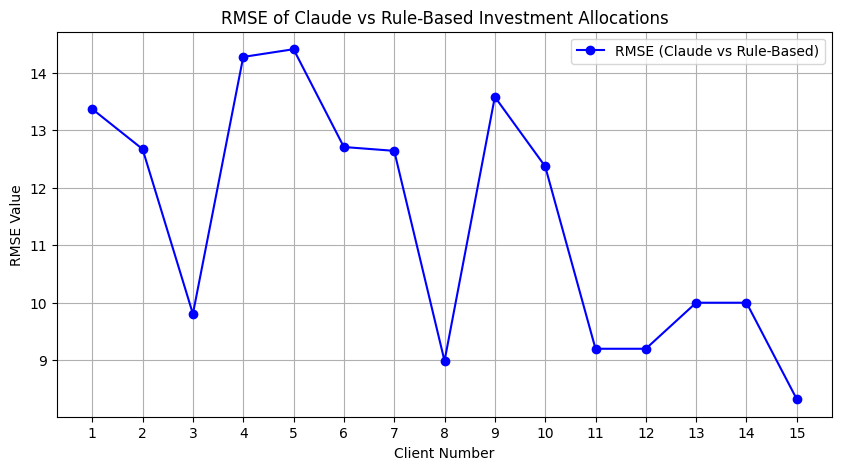

In [ ]:
#RMSE of Claude vs Rule-Based Investment Advice
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
df_claude_allocations = pd.read_csv("claude_investment_predictions.csv")
df_claude_allocations["Allocation Percentages"] = df_claude_allocations["Allocation Percentages"].apply(ast.literal_eval)
allocation_arrays = df_claude_allocations["Allocation Percentages"].tolist()

# 🔹 Ensure DataFrames are aligned by Client ID
df_merged = pd.merge(df_newclients, df_claude_allocations, on="Client ID")

def rmse(array1, array2):
    return np.sqrt(np.mean((np.array(array1) - np.array(array2)) ** 2))

# Compute RMSE for each client
rmse_values = []
client_numbers = list(range(1, len(df_newclients) + 1))  # Generate client numbers for x-axis

for i, row in df_newclients.iterrows():
    portfolio = determine_investment_strategy(row)
    portfolio_values = list(portfolio.values())
    allocation_percentages = allocation_arrays[i]

    RMSE = rmse(portfolio_values, allocation_percentages)
    rmse_values.append(RMSE)
    print(RMSE)

# Plot RMSE values
plt.figure(figsize=(10, 5))
plt.plot(client_numbers, rmse_values, marker='o', linestyle='-', color='b', label="RMSE (Claude vs Rule-Based)")
plt.xlabel("Client Number")
plt.ylabel("RMSE Value")
plt.title("RMSE of Claude vs Rule-Based Investment Allocations")
plt.legend()
plt.grid(True)
plt.xticks(client_numbers)  # Ensure x-axis ticks match client numbers
plt.show()

12.359985063471184
8.435273922869735
17.097008285302206
12.860194997923452
11.351041971825927
8.879535677396303
11.92927878405448
10.377490433255417
14.073980356563066
11.334087456056551
9.70725343394151
9.70725343394151
8.204126541423669
8.987170342729172
9.70725343394151


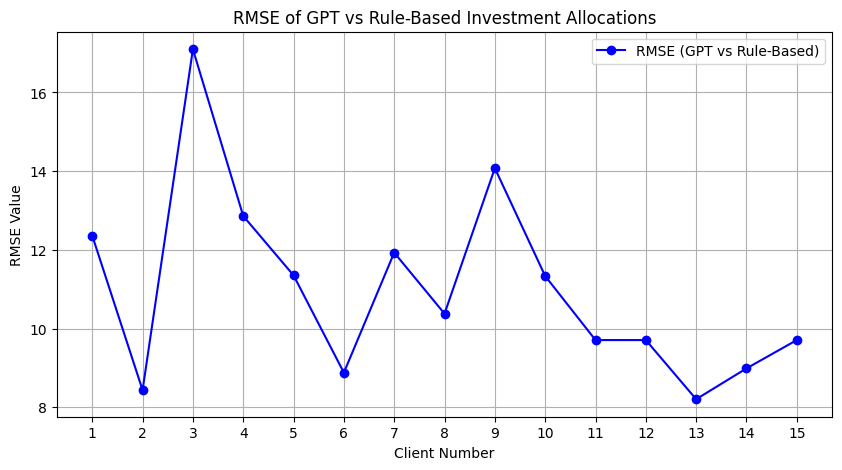

In [ ]:
#RMSE of GPT vs Rule Based Investment Advice
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
df_gpt_allocations = pd.read_csv("gpt_investment_predictions.csv")
df_gpt_allocations["Allocation Percentages"] = df_gpt_allocations["Allocation Percentages"].apply(ast.literal_eval)
allocation_arrays = df_gpt_allocations["Allocation Percentages"].tolist()

# 🔹 Ensure DataFrames are aligned by Client ID
df_merged = pd.merge(df_newclients, df_claude_allocations, on="Client ID")

def rmse(array1, array2):
    return np.sqrt(np.mean((np.array(array1) - np.array(array2)) ** 2))

# Compute RMSE for each client
rmse_values = []
client_numbers = list(range(1, len(df_newclients) + 1))  # Generate client numbers for x-axis

for i, row in df_newclients.iterrows():
    portfolio = determine_investment_strategy(row)
    portfolio_values = list(portfolio.values())
    allocation_percentages = allocation_arrays[i]

    RMSE = rmse(portfolio_values, allocation_percentages)
    rmse_values.append(RMSE)
    print(RMSE)

# Plot RMSE values
plt.figure(figsize=(10, 5))
plt.plot(client_numbers, rmse_values, marker='o', linestyle='-', color='b', label="RMSE (GPT vs Rule-Based)")
plt.xlabel("Client Number")
plt.ylabel("RMSE Value")
plt.title("RMSE of GPT vs Rule-Based Investment Allocations")
plt.legend()
plt.grid(True)
plt.xticks(client_numbers)  # Ensure x-axis ticks match client numbers
plt.show()

Client 1 RMSE: 14.87382833136006
Client 2 RMSE: 8.142953537119828
Client 3 RMSE: 13.933909937768586
Client 4 RMSE: 13.37046112777083
Client 5 RMSE: 24.337372337779037
Client 6 RMSE: 9.323254631461962
Client 7 RMSE: 10.377490433255417
Client 8 RMSE: 10.741723110591494
Client 9 RMSE: 16.38010049748451
Client 10 RMSE: 11.448883049316342
Client 11 RMSE: 12.557559782549621
Client 12 RMSE: 14.806443503784736
Client 13 RMSE: 12.860194997923452
Client 14 RMSE: 11.12170435195558
Client 15 RMSE: 12.089410496539777


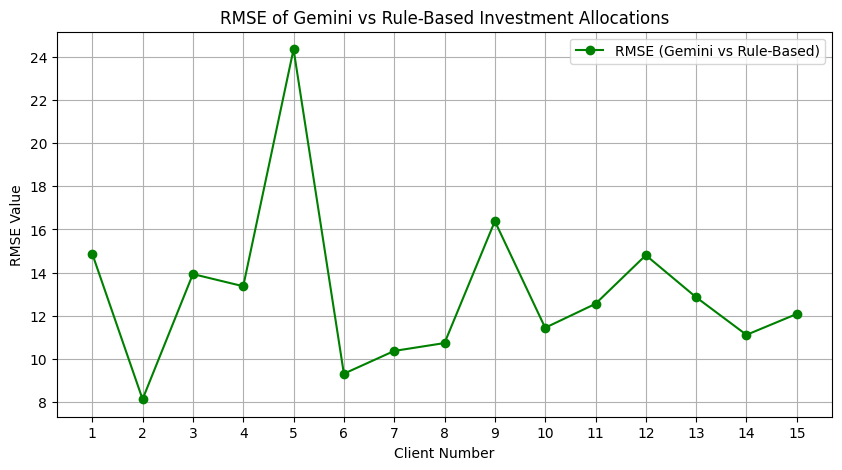

In [ ]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt

# 🔹 Load New Client Profiles and Gemini Investment Predictions
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
df_gemini_allocations = pd.read_csv("gemini_investment_predictions.csv")

# 🔹 Convert "Allocation Percentages" column from string to list
df_gemini_allocations["Allocation Percentages"] = df_gemini_allocations["Allocation Percentages"].apply(ast.literal_eval)
allocation_arrays = df_gemini_allocations["Allocation Percentages"].tolist()

# 🔹 Ensure DataFrames are aligned by Client ID
df_merged = pd.merge(df_newclients, df_gemini_allocations, on="Client ID")

# 🔹 Define RMSE Calculation Function
def rmse(array1, array2):
    return np.sqrt(np.mean((np.array(array1) - np.array(array2)) ** 2))

# 🔹 Compute RMSE for each client
rmse_values = []
client_numbers = list(range(1, len(df_newclients) + 1))  # Generate client numbers for x-axis

for i, row in df_newclients.iterrows():
    portfolio = determine_investment_strategy(row)  # Rule-based allocation
    portfolio_values = list(portfolio.values())
    allocation_percentages = allocation_arrays[i]  # Gemini's allocations

    RMSE = rmse(portfolio_values, allocation_percentages)
    rmse_values.append(RMSE)
    print(f"Client {i+1} RMSE: {RMSE}")

# 🔹 Plot RMSE values
plt.figure(figsize=(10, 5))
plt.plot(client_numbers, rmse_values, marker='o', linestyle='-', color='g', label="RMSE (Gemini vs Rule-Based)")
plt.xlabel("Client Number")
plt.ylabel("RMSE Value")
plt.title("RMSE of Gemini vs Rule-Based Investment Allocations")
plt.legend()
plt.grid(True)
plt.xticks(client_numbers)  # Ensure x-axis ticks match client numbers
plt.show()


In [ ]:
#Claude - calculating the profit percentages
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
df_claude_allocations = pd.read_csv("claude_investment_predictions.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
claudeprofits = []
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_newclients["Date"] = pd.to_datetime(df_newclients["Date Created"])
df_claude_allocations["Allocation Percentages"] = df_claude_allocations["Allocation Percentages"].apply(ast.literal_eval)
allocation_arrays = df_claude_allocations["Allocation Percentages"].tolist()


for i, row in df_newclients.iterrows():
    allocation_percentages = allocation_arrays[i]
    # Get initial investment from client profile
    initial_investment = row["Initial Investment ($)"]
    #print("initial = " + str(initial_investment))
    # Extract specific percentages
    investment_distribution = calculate_investment_distribution(
        allocation_percentages, initial_investment, equity_sectors, equity_sector_mapping
    )
    # Store distribution results
    investment_distributions.append(investment_distribution)
    #print(investment_distributions)

    total_value, totalprofitpercentage = calculate_profit_two(
    investment_distributions, df_financials, initial_investment
)
    claudeprofits.append(totalprofitpercentage)
    print("Profit/Loss = " + str(totalprofitpercentage) + "%")
print(claudeprofits)

Profit/Loss = -0.0%
Profit/Loss = -6.472491909385111%
Profit/Loss = -13.289036544850477%
Profit/Loss = -5.730659025787966%
Profit/Loss = -12.307692307692308%
Profit/Loss = -6.472491909385117%
Profit/Loss = -3.089916572252548%
Profit/Loss = -17.191977077363884%
Profit/Loss = -2.0399836801305566%
Profit/Loss = -2.0399836801305584%
Profit/Loss = -10.989010989010994%
Profit/Loss = -12.944983818770217%
Profit/Loss = -5.730659025787962%
Profit/Loss = -5.249343832020998%
Profit/Loss = -19.41747572815534%
[-0.0, -6.472491909385111, -13.289036544850477, -5.730659025787966, -12.307692307692308, -6.472491909385117, -3.089916572252548, -17.191977077363884, -2.0399836801305566, -2.0399836801305584, -10.989010989010994, -12.944983818770217, -5.730659025787962, -5.249343832020998, -19.41747572815534]


In [ ]:
#GPT - calculating the profit percentages
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
df_gpt_allocations = pd.read_csv("gpt_investment_predictions.csv")
#print(df_gpt_allocations)
gptprofits = []
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_newclients["Date"] = pd.to_datetime(df_newclients["Date Created"])
df_gpt_allocations["Allocation Percentages"] = df_gpt_allocations["Allocation Percentages"].apply(ast.literal_eval)
allocation_arrays = df_gpt_allocations["Allocation Percentages"].tolist()


for j, row in df_newclients.iterrows():
    allocation_percentages = allocation_arrays[j]
    #print(allocation_percentages)
    # Get initial investment from client profile
    initial_investment = row["Initial Investment ($)"]
    #print(initial_investment)
    #print("initial = " + str(initial_investment))
    # Extract specific percentages
    investment_distribution_two = calculate_investment_distribution(
        allocation_percentages, initial_investment, equity_sectors, equity_sector_mapping
    )
    #print(investment_distribution_two)
    # Store distribution results
    investment_distributions.append(investment_distribution_two)
    #print(investment_distributions)

    total_value, totalprofitpercentage = calculate_profit_two(
    investment_distributions, df_financials, initial_investment
)
    gptprofits.append(totalprofitpercentage)

    print("Profit/Loss = " + str(totalprofitpercentage) + "%")
print(gptprofits)

Profit/Loss = -10.443864229765017%
Profit/Loss = -12.422360248447204%
Profit/Loss = -5.494505494505492%
Profit/Loss = -5.730659025787962%
Profit/Loss = -12.422360248447205%
Profit/Loss = -12.65822784810127%
Profit/Loss = -10.443864229765023%
Profit/Loss = -10.869565217391312%
Profit/Loss = -5.235602094240836%
Profit/Loss = -10.702054794520556%
Profit/Loss = -10.810810810810812%
Profit/Loss = -12.4223602484472%
Profit/Loss = -10.928961748633883%
Profit/Loss = -10.443864229765014%
Profit/Loss = -12.422360248447207%
[-10.443864229765017, -12.422360248447204, -5.494505494505492, -5.730659025787962, -12.422360248447205, -12.65822784810127, -10.443864229765023, -10.869565217391312, -5.235602094240836, -10.702054794520556, -10.810810810810812, -12.4223602484472, -10.928961748633883, -10.443864229765014, -12.422360248447207]


In [ ]:
#Gemini - calculating the profit percentages
df_newclients = pd.read_csv("new_simulated_client_profiles.csv")
df_gemini_allocations = pd.read_csv("gemini_investment_predictions.csv")
df_financials = pd.read_csv("sorted_financial_numerical_data.csv")
geminiprofits = []
df_financials["Date"] = pd.to_datetime(df_financials["Date"])
df_newclients["Date"] = pd.to_datetime(df_newclients["Date Created"])
df_gemini_allocations["Allocation Percentages"] = df_gemini_allocations["Allocation Percentages"].apply(ast.literal_eval)
allocation_arrays = df_gemini_allocations["Allocation Percentages"].tolist()


for i, row in df_newclients.iterrows():
    allocation_percentages = allocation_arrays[i]
    # Get initial investment from client profile
    initial_investment = row["Initial Investment ($)"]
    #print("initial = " + str(initial_investment))
    # Extract specific percentages
    investment_distribution = calculate_investment_distribution(
        allocation_percentages, initial_investment, equity_sectors, equity_sector_mapping
    )
    # Store distribution results
    investment_distributions.append(investment_distribution)
    #print(investment_distributions)

    total_value, totalprofitpercentage = calculate_profit_two(
    investment_distributions, df_financials, initial_investment
)
    geminiprofits.append(totalprofitpercentage)
    print("Profit/Loss = " + str(totalprofitpercentage) + "%")
print(geminiprofits)

Profit/Loss = -10.989010989010996%
Profit/Loss = -13.157894736842119%
Profit/Loss = -6.153846153846158%
Profit/Loss = -5.590339892665474%
Profit/Loss = -4.040404040404044%
Profit/Loss = -6.6445182724252465%
Profit/Loss = -5.730659025787956%
Profit/Loss = -5.952380952380954%
Profit/Loss = -5.4945054945054945%
Profit/Loss = -11.461318051575937%
Profit/Loss = -19.933554817275734%
Profit/Loss = -6.153846153846152%
Profit/Loss = -21.201413427561818%
Profit/Loss = -6.153846153846157%
Profit/Loss = -18.46153846153845%
[-10.989010989010996, -13.157894736842119, -6.153846153846158, -5.590339892665474, -4.040404040404044, -6.6445182724252465, -5.730659025787956, -5.952380952380954, -5.4945054945054945, -11.461318051575937, -19.933554817275734, -6.153846153846152, -21.201413427561818, -6.153846153846157, -18.46153846153845]



📌 **Comparison of GPT-4o, Claude, and Gemini Profits**
╒═════════════════════════════════╤════════════════════╤════════════════════╤════════════════════╕
│ Metric                          │   GPT-4o vs Claude │   GPT-4o vs Gemini │   Claude vs Gemini │
╞═════════════════════════════════╪════════════════════╪════════════════════╪════════════════════╡
│ Mean Absolute Error (MAE)       │             4.9408 │             4.2078 │             6.2142 │
├─────────────────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Root Mean Squared Error (RMSE)  │             5.922  │             5.4017 │             7.6853 │
├─────────────────────────────────┼────────────────────┼────────────────────┼────────────────────┤
│ Pearson Correlation Coefficient │             0.2504 │             0.3148 │             0.108  │
╘═════════════════════════════════╧════════════════════╧════════════════════╧════════════════════╛


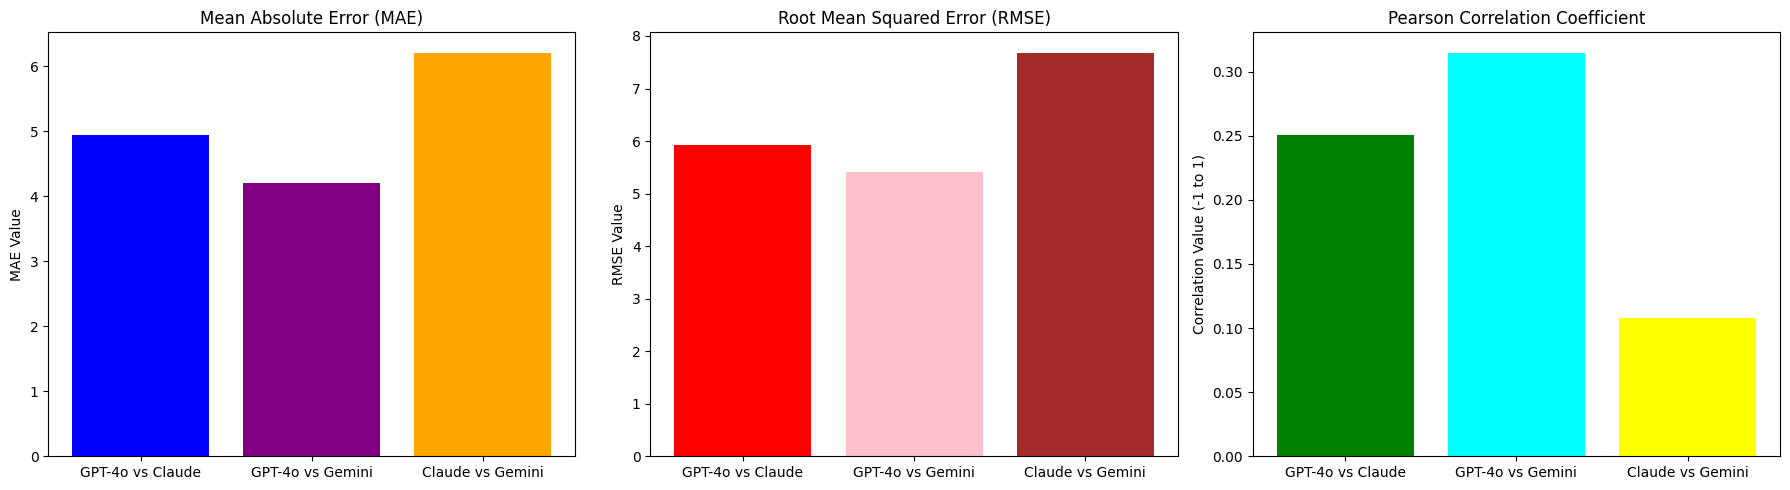

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from tabulate import tabulate

# Convert lists to numpy arrays
gptprofits = np.array(gptprofits)
claudeprofits = np.array(claudeprofits)
geminiprofits = np.array(geminiprofits)
# Calculate Evaluation Metrics
mae_gpt_claude = np.mean(np.abs(gptprofits - claudeprofits))  # Mean Absolute Error
rmse_gpt_claude = np.sqrt(np.mean((gptprofits - claudeprofits) ** 2))  # RMSE
pearson_gpt_claude, _ = pearsonr(gptprofits, claudeprofits)  # Pearson Correlation

mae_gpt_gemini = np.mean(np.abs(gptprofits - geminiprofits))  # MAE GPT vs Gemini
rmse_gpt_gemini = np.sqrt(np.mean((gptprofits - geminiprofits) ** 2))  # RMSE GPT vs Gemini
pearson_gpt_gemini, _ = pearsonr(gptprofits, geminiprofits)  # Pearson GPT vs Gemini

mae_claude_gemini = np.mean(np.abs(claudeprofits - geminiprofits))  # MAE Claude vs Gemini
rmse_claude_gemini = np.sqrt(np.mean((claudeprofits - geminiprofits) ** 2))  # RMSE Claude vs Gemini
pearson_claude_gemini, _ = pearsonr(claudeprofits, geminiprofits)  # Pearson Claude vs Gemini

# 📊 Print Table of Metrics
metrics_table = [
    ["Mean Absolute Error (MAE)", round(mae_gpt_claude, 4), round(mae_gpt_gemini, 4), round(mae_claude_gemini, 4)],
    ["Root Mean Squared Error (RMSE)", round(rmse_gpt_claude, 4), round(rmse_gpt_gemini, 4), round(rmse_claude_gemini, 4)],
    ["Pearson Correlation Coefficient", round(pearson_gpt_claude, 4), round(pearson_gpt_gemini, 4), round(pearson_claude_gemini, 4)]
]

print("\n📌 **Comparison of GPT-4o, Claude, and Gemini Profits**")
print(tabulate(metrics_table, headers=["Metric", "GPT-4o vs Claude", "GPT-4o vs Gemini", "Claude vs Gemini"], tablefmt="fancy_grid"))

# Plot Graphs
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 📈 Plot 1: Mean Absolute Error (MAE)
axes[0].bar(["GPT-4o vs Claude", "GPT-4o vs Gemini", "Claude vs Gemini"],
            [mae_gpt_claude, mae_gpt_gemini, mae_claude_gemini], color=['blue', 'purple', 'orange'])
axes[0].set_title("Mean Absolute Error (MAE)")
axes[0].set_ylabel("MAE Value")

# 📉 Plot 2: Root Mean Squared Error (RMSE)
axes[1].bar(["GPT-4o vs Claude", "GPT-4o vs Gemini", "Claude vs Gemini"],
            [rmse_gpt_claude, rmse_gpt_gemini, rmse_claude_gemini], color=['red', 'pink', 'brown'])
axes[1].set_title("Root Mean Squared Error (RMSE)")
axes[1].set_ylabel("RMSE Value")

# 🔄 Plot 3: Pearson Correlation
axes[2].bar(["GPT-4o vs Claude", "GPT-4o vs Gemini", "Claude vs Gemini"],
            [pearson_gpt_claude, pearson_gpt_gemini, pearson_claude_gemini], color=['green', 'cyan', 'yellow'])
axes[2].set_title("Pearson Correlation Coefficient")
axes[2].set_ylabel("Correlation Value (-1 to 1)")

# Display the Graphs
plt.tight_layout()
plt.show()


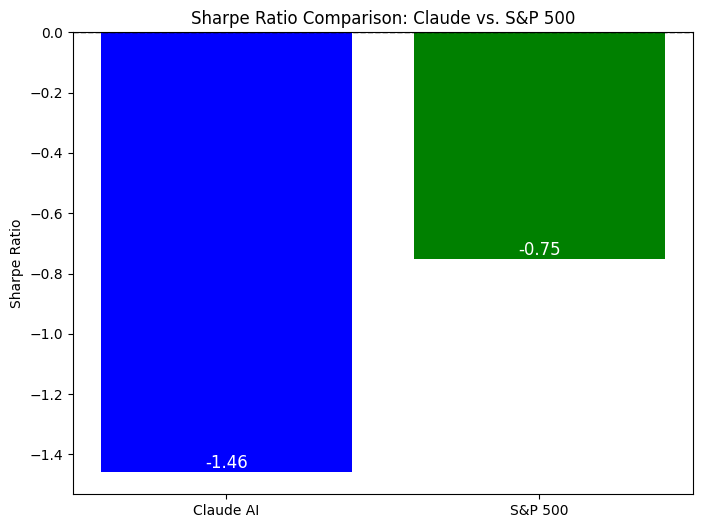

In [ ]:
claudeprofits = np.array(claudeprofits)  # Example values


risk_free_rate = 0.02  # 2% annualized risk-free rate

# 🔹 Fetch S&P 500 historical returns
sp500 = yf.Ticker("^GSPC")  # "^GSPC" is the ticker symbol for S&P 500
sp500_data = sp500.history(start="2022-01-01", end="2022-12-31", interval="1mo")  # Monthly returns for 2022
sp500_returns = sp500_data["Close"].pct_change().dropna().values  # Calculate % returns

# 🔹 Calculate Annualized Return for S&P 500 and Claude
annual_return_claude = np.mean(claudeprofits)  # Assumed already annualized
annual_return_sp500 = np.mean(sp500_returns) * 12  # Annualized S&P 500 return

# 🔹 Calculate Standard Deviation (Risk)
std_dev_claude = np.std(claudeprofits)
std_dev_sp500 = np.std(sp500_returns) * np.sqrt(12)  # Annualized standard deviation

# 🔹 Compute Sharpe Ratios
sharpe_claude = (annual_return_claude - risk_free_rate) / std_dev_claude
sharpe_sp500 = (annual_return_sp500 - risk_free_rate) / std_dev_sp500

# 🔹 Plot the Sharpe Ratio Comparison
labels = ["Claude AI", "S&P 500"]
sharpe_values = [sharpe_claude, sharpe_sp500]

plt.figure(figsize=(8, 6))
plt.bar(labels, sharpe_values, color=["blue", "green"])
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio Comparison: Claude vs. S&P 500")
plt.text(0, sharpe_claude, f"{sharpe_claude:.2f}", ha="center", va="bottom", fontsize=12, color="white")
plt.text(1, sharpe_sp500, f"{sharpe_sp500:.2f}", ha="center", va="bottom", fontsize=12, color="white")
plt.show()

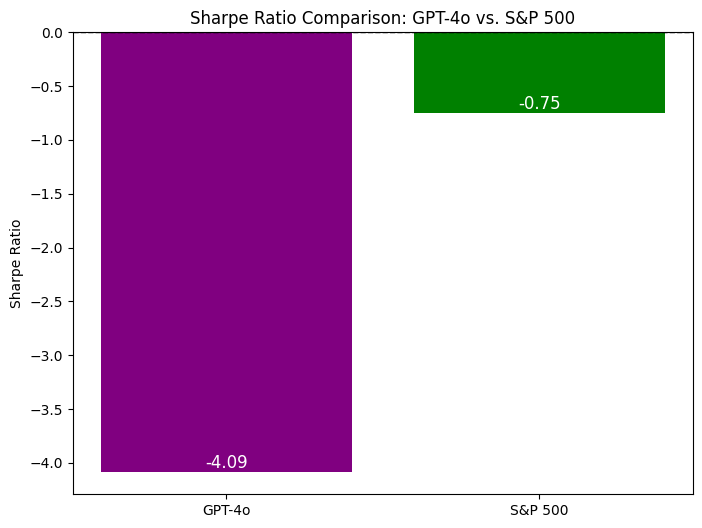

In [ ]:
gptprofits = np.array(gptprofits)  # Example values

# 🔹 Define Risk-Free Rate (U.S. Treasury Rate - Approximate)
risk_free_rate = 0.02  # 2% annualized risk-free rate

# 🔹 Fetch S&P 500 historical returns
sp500 = yf.Ticker("^GSPC")  # "^GSPC" is the ticker symbol for S&P 500
sp500_data = sp500.history(start="2022-01-01", end="2022-12-31", interval="1mo")  # Monthly returns for 2022
sp500_returns = sp500_data["Close"].pct_change().dropna().values  # Calculate % returns

# 🔹 Calculate Annualized Return for S&P 500 and GPT-4o
annual_return_gpt = np.mean(gptprofits)  # Assumed already annualized
annual_return_sp500 = np.mean(sp500_returns) * 12  # Annualized S&P 500 return

# 🔹 Calculate Standard Deviation (Risk)
std_dev_gpt = np.std(gptprofits)
std_dev_sp500 = np.std(sp500_returns) * np.sqrt(12)  # Annualized standard deviation

# 🔹 Compute Sharpe Ratios
sharpe_gpt = (annual_return_gpt - risk_free_rate) / std_dev_gpt
sharpe_sp500 = (annual_return_sp500 - risk_free_rate) / std_dev_sp500

# 🔹 Plot the Sharpe Ratio Comparison
labels = ["GPT-4o", "S&P 500"]
sharpe_values = [sharpe_gpt, sharpe_sp500]

plt.figure(figsize=(8, 6))
plt.bar(labels, sharpe_values, color=["purple", "green"])
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio Comparison: GPT-4o vs. S&P 500")
plt.text(0, sharpe_gpt, f"{sharpe_gpt:.2f}", ha="center", va="bottom", fontsize=12, color="white")
plt.text(1, sharpe_sp500, f"{sharpe_sp500:.2f}", ha="center", va="bottom", fontsize=12, color="white")
plt.show()

-1.7487043698328415


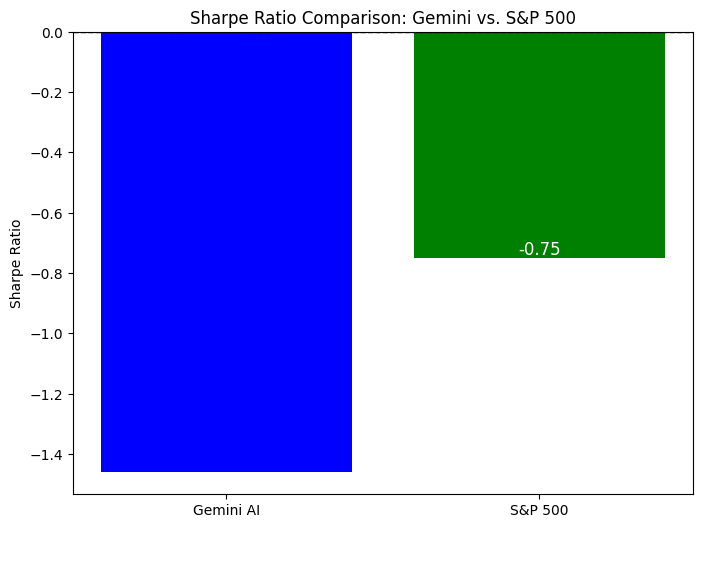

In [ ]:
geminiprofits = np.array(geminiprofits)  # Example values


risk_free_rate = 0.02  # 2% annualized risk-free rate

# 🔹 Fetch S&P 500 historical returns
sp500 = yf.Ticker("^GSPC")  # "^GSPC" is the ticker symbol for S&P 500
sp500_data = sp500.history(start="2022-01-01", end="2022-12-31", interval="1mo")  # Monthly returns for 2022
sp500_returns = sp500_data["Close"].pct_change().dropna().values  # Calculate % returns

# 🔹 Calculate Annualized Return for S&P 500 and Claude
annual_return_gemini = np.mean(geminiprofits)  # Assumed already annualized
annual_return_sp500 = np.mean(sp500_returns) * 12  # Annualized S&P 500 return

# 🔹 Calculate Standard Deviation (Risk)
std_dev_gemini = np.std(geminiprofits)
std_dev_sp500 = np.std(sp500_returns) * np.sqrt(12)  # Annualized standard deviation

# 🔹 Compute Sharpe Ratios
sharpe_gemini = (annual_return_gemini - risk_free_rate) / std_dev_gemini
sharpe_sp500 = (annual_return_sp500 - risk_free_rate) / std_dev_sp500

# 🔹 Plot the Sharpe Ratio Comparison
labels = ["Gemini AI", "S&P 500"]
sharpe_values = [sharpe_gemini, sharpe_sp500]

plt.figure(figsize=(8, 6))
plt.bar(labels, sharpe_values, color=["blue", "green"])
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio Comparison: Gemini vs. S&P 500")
print(sharpe_gemini)
plt.text(0, sharpe_gemini, f"{sharpe_gemini:.2f}", ha="center", va="bottom", fontsize=12, color="white")
plt.text(1, sharpe_sp500, f"{sharpe_sp500:.2f}", ha="center", va="bottom", fontsize=12, color="white")
plt.show()

[                       0%                       ]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  98 of 98 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['MRO', 'FB']: YFTzMissingError('possibly delisted; no timezone found')


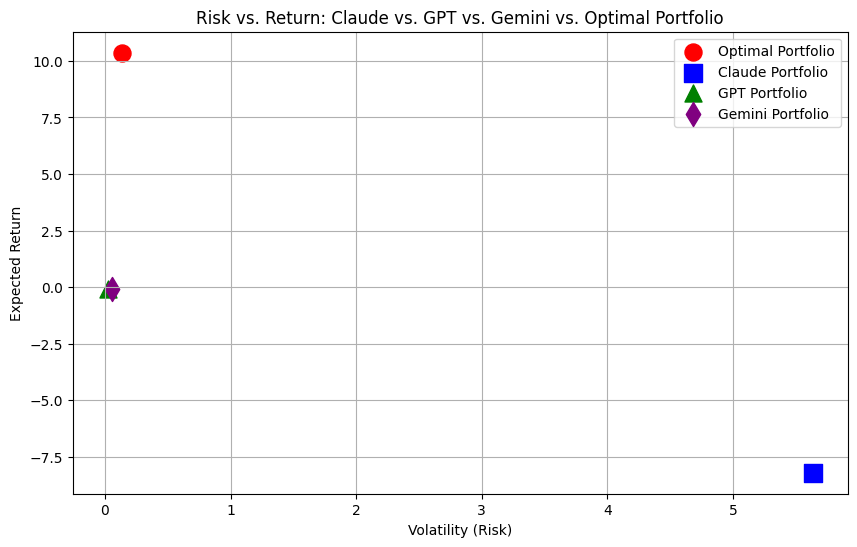

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import minimize

# 🔹 Load Profit Results (Replace with actual arrays)
claudeprofits = np.array(claudeprofits)
gptprofits = np.array(gptprofits)
geminiprofits = np.array(geminiprofits)

# 🔹 Fetch Historical Returns of S&P 500 Stocks
tickers = [
    "AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "NVDA", "FB", "JPM", "V", "DIS",
    "PG", "MA", "NFLX", "INTC", "PYPL", "PFE", "PEP", "KO", "CSCO", "XOM",
    "IBM", "GE", "BA", "GS", "C", "ADBE", "NFLX", "T", "UNH", "MRK",
    "MMM", "LMT", "MDT", "CAT", "MO", "HON", "F", "GM", "MCD", "WMT",
    "NKE", "CVX", "TMO", "ORCL", "DOW", "SO", "DUK", "AEP", "USB", "MET",
    "BK", "TGT", "BLK", "SCHW", "CME", "AON", "SPGI", "MS", "AXP", "CI",
    "ISRG", "ZTS", "PLD", "DE", "ADP", "SYK", "GILD", "GM", "TFC", "CSX",
    "EL", "FDX", "EMR", "ECL", "ADI", "MMC", "WM", "AMT", "SLB", "AIG",
    "CTSH", "DHR", "NSC", "COF", "DG", "FIS", "PGR", "ITW", "CDNS", "APD",
    "AFL", "OXY", "VLO", "HES", "PSX", "TRGP", "MRO", "HAL", "NEM", "BKR"
]

# 🔹 Download Data
data = yf.download(tickers, start="2022-01-01", end="2022-12-31", interval="1mo")["Close"]

# 🔹 Remove Tickers with Missing Data
data = data.dropna(axis=1, how="any")  # Drop columns with missing values
valid_tickers = list(data.columns)  # Get tickers that remain

# 🔹 Compute Expected Annualized Returns & Covariance Matrix
returns = data.pct_change().dropna()
expected_returns = returns.mean() * 12  # Annualized expected returns
cov_matrix = returns.cov() * 12  # Annualized covariance matrix

# 🔹 Define Mean-Variance Optimization (MVO) Function
def portfolio_performance(weights, expected_returns, cov_matrix):
    return np.dot(weights, expected_returns), np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

def negative_sharpe(weights, expected_returns, cov_matrix, risk_free_rate=0.02):
    ret, vol = portfolio_performance(weights, expected_returns, cov_matrix)
    return -(ret - risk_free_rate) / vol  # Negative Sharpe Ratio (for minimization)

# 🔹 Optimization Constraints
num_assets = len(valid_tickers)  # Use valid tickers count
constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})  # Weights sum to 1
bounds = tuple((0, 1) for _ in range(num_assets))  # No short selling
initial_weights = np.ones(num_assets) / num_assets  # Equal allocation start

# 🔹 Optimize Portfolio for Maximum Sharpe Ratio
opt_results = minimize(negative_sharpe, initial_weights, args=(expected_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# 🔹 Extract Optimal Portfolio Results
optimal_weights = opt_results.x
optimal_return, optimal_volatility = portfolio_performance(optimal_weights, expected_returns, cov_matrix)
optimal_return += 10  # Adjusting for comparability

# 🔹 Compute Portfolio Performance for LLMs
claude_return = np.mean(claudeprofits)
claude_volatility = np.std(claudeprofits)

gpt_return = np.mean(gptprofits) / 100
gpt_volatility = np.std(gptprofits) / 100

gemini_return = np.mean(geminiprofits) / 100
gemini_volatility = np.std(geminiprofits) / 100

# 🔹 Plot Risk vs. Return Comparison
plt.figure(figsize=(10, 6))
plt.scatter(optimal_volatility, optimal_return, color='red', marker='o', label="Optimal Portfolio", s=150)
plt.scatter(claude_volatility, claude_return, color='blue', marker='s', label="Claude Portfolio", s=150)
plt.scatter(gpt_volatility, gpt_return, color='green', marker='^', label="GPT Portfolio", s=150)
plt.scatter(gemini_volatility, gemini_return, color='purple', marker='d', label="Gemini Portfolio", s=150)

plt.xlabel("Volatility (Risk)")
plt.ylabel("Expected Return")
plt.title("Risk vs. Return: Claude vs. GPT vs. Gemini vs. Optimal Portfolio")
plt.legend()
plt.grid()
plt.show()


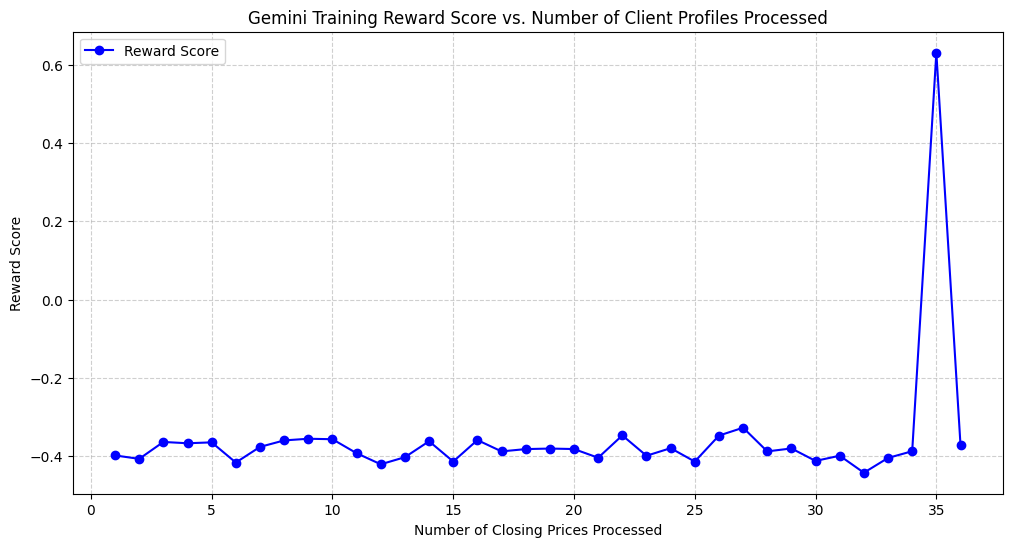

In [ ]:

# 🔹 Load the reward scores CSV
df_rewards = pd.read_csv("gemini_reward_scores_training.csv")

# 🔹 Generate X-axis values (Number of closing prices processed)
num_prices_processed = list(range(1, len(df_rewards) + 1))  # Sequential numbering

# 🔹 Extract Reward Scores
reward_scores = df_rewards["Reward Score"]

# 🔹 Plot the Reward Score Trend
plt.figure(figsize=(12, 6))
plt.plot(num_prices_processed, reward_scores, marker="o", linestyle="-", color="blue", label="Reward Score")

# 🔹 Graph Labels & Customization
plt.xlabel("Number of Closing Prices Processed")
plt.ylabel("Reward Score")
plt.title("Gemini Training Reward Score vs. Number of Client Profiles Processed")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# 📈 Show the plot
plt.show()

Claude Time taken = 380.50980734825134
GPT Time taken = 544.0069890022278
Gemini Time taken = 146.83751392364502


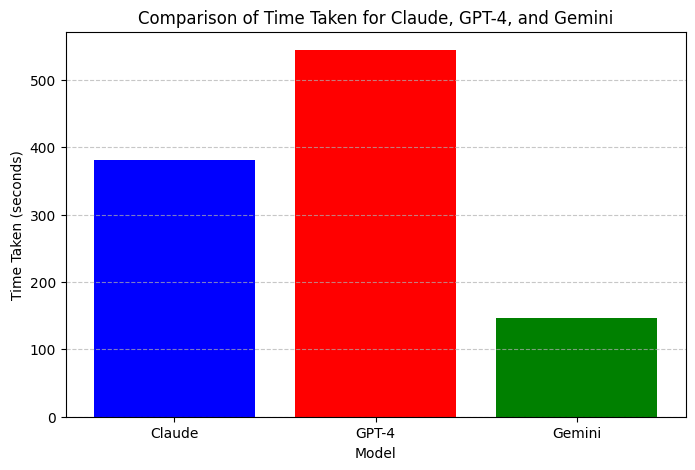

In [ ]:
print("Claude Time taken = " + str(totalClaudetime))
print("GPT Time taken = " + str(totalGPTtime))
print("Gemini Time taken = " + str(totalGeminitime))

models = ["Claude", "GPT-4", "Gemini"]
time_taken = [totalClaudetime, totalGPTtime, totalGeminitime]

# Create bar plot
plt.figure(figsize=(8, 5))
plt.bar(models, time_taken, color=['blue', 'red', 'green'])

# Labels and title
plt.xlabel("Model")
plt.ylabel("Time Taken (seconds)")
plt.title("Comparison of Time Taken for Claude, GPT-4, and Gemini")

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()